# Replication Notebook

Code for the data analysis for the paper "Exploring the relationship between performance metrics and cost saving potential of defect prediction models"

### Imports

In [1]:
import sys
!{sys.executable} -m pip install graphviz==0.18 matplotlib==3.3.4 numpy==1.20.2 pandas==1.2.4 seaborn==0.11.1 scipy==1.6.2 scikit-learn==0.24.2 statsmodels==0.12.2

In [2]:
import os
import re
import time
import warnings


import graphviz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy.optimize import differential_evolution
from scipy.stats import spearmanr
from scipy.stats.distributions import norm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

### Settings

In [3]:
# Remove the following line, in case you have trouble. Maybe some hidden warning gives you a clue. 
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 14})
heatmap_fontsize = 11

pd.set_option('display.max_columns', 40)

FIRST_NUM_FEATURE_IDX = 2
RANDOM_STATE = 42
RERUN_LOGIT_OPTIMIZER = False

DATA_PATH = "data"
CSV_FILENAME_BOOTSTRAP = "metrics_vs_costsaving_bootstrap_experiment.csv"
CSV_FILENAME_GENERALIZATION = "metrics_vs_costsaving_realistic_settings.csv"
CSV_FILENAME_TRAINING_DATA = "train_data.csv"
CSV_FILENAME_LOGIT_OPTIM = "logit_optim_grid_search.csv"

PLOTS_DIR = os.path.join("plots")
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

### Utilities

In [4]:
def dataset_overview(df):
    """Gives an overview of the dataframe to check for its completeness."""
    num_releases = df["release"].nunique()
    instances_per_release = df["num_test"].groupby(df["release"]).count().unique().tolist()
    print(f"Number of releases: {num_releases}")
    print(f"Instances per release: {instances_per_release}")
    print(f"Total number of instances: {df.shape[0]}\n")
    print(f"Overall number of NaN:               {df.isna().sum().sum()}")
    print(f"Overall number of NaN (no 'diff'):   {df.drop('diff', axis=1).isna().sum().sum()}")
    print(f"Number of rows with NaN:             {df[df.isna().any(axis=1)].shape[0]}")
    print(f"Number of rows with NaN (no 'diff'): {df[df.drop('diff', axis=1).isna().any(axis=1)].shape[0]}")
    print("\nNaNs per variable:")
    print(df.isna().sum().loc[df.isna().sum()>0] )
    print("\ninfs per variable:")
    inf_array = np.isinf(df.drop(["configuration","release","potential"], axis=1)).sum()
    print(inf_array[inf_array>0])

def no_bugs_instances_costs(df):
    """Analyze the cost for instances without defects and returns the dataframe without those instances.

    These instances need to be analyzed separately and filtered from the overall data, as multiple metrics become invalid.
    """
    no_bugs_test = df.loc[df['bias_test']==0]
    no_bugs_train = df.loc[df['bias_train_processed']==0]
    print(f"Number of instances without any defects in the test data: {no_bugs_test.shape[0]}")
    print(f"Costs through QA efforts for false positives in those instances:")
    print(f"min: {no_bugs_test['cost'].min():.0f}, max: {no_bugs_test['cost'].max():.0f}, median: {no_bugs_test['cost'].median():.2f}, sum: {no_bugs_test['cost'].sum():.0f}\n")
    print(f"Number of instances without any defects in the processed training data: {no_bugs_train.shape[0]}")
    print(f"Costs through QA efforts for false positives in those instances:")
    print(f"min: {no_bugs_train['cost'].min():.0f}, max: {no_bugs_train['cost'].max():.0f}, median: {no_bugs_train['cost'].median():.2f}, sum: {no_bugs_train['cost'].sum():.0f}")
    return df.loc[(df['bias_test']!=0) & (df['bias_train_processed']!=0)]

def dataset_descriptive_stats(df):
    """Returns a dataframe containing descriptive statistics for every feature."""
    desc_stats = pd.DataFrame(columns=df.columns)
    desc_stats = desc_stats.append((df.mean(axis=0).rename("mean")))
    desc_stats = desc_stats.append(df.std(axis=0).rename("std"))
    desc_stats = desc_stats.append(df.min(axis=0, numeric_only=True).rename("min"))
    desc_stats = desc_stats.append(df.max(axis=0, numeric_only=True).rename("max"))
    desc_stats = desc_stats.append(df.median(axis=0).rename("median"))
    desc_stats = desc_stats.append(df.quantile(0.25).rename("25q"))
    desc_stats = desc_stats.append(df.quantile(0.75).rename("75q"))
    return desc_stats

def bar_plot_wrapper(data, x_labels, data_std=None, set_labels=None, title="Logit model coefficients",
                     xlabel="feature", ylabel="coefficients", figsize=(8, 4), rotate_ticks=False):
    """Wrapper around matplotlib's bar function in order to plot coefficient diagrams."""

    length = data.shape[0]
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.8 / data.shape[1]
    x = np.arange(length)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.4)

    for i in range(data.shape[1]):
        if data_std is None and set_labels is None:
            ax.bar(x + (i * width), data[:, i], width)
        elif set_labels is None:
            ax.bar(x + (i * width), data[:, i], width, yerr=data_std[:, i])
        elif data_std is None:
            ax.bar(x + (i * width), data[:, i], width, label=set_labels[i])
        else:
            ax.bar(x + (i * width), data[:, i], width, label=set_labels[i], yerr=data_std[:, i])

    ax.set_xticks(x + width * (data.shape[1] - 1) / 2)
    ax.set_xticklabels(x_labels)
    if rotate_ticks:
        plt.xticks(rotation=90)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if set_labels is not None:
        ax.legend()
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.2)
    for j in range(1, data.shape[0]):
        plt.axvline(x=x[j] + width * (data.shape[1] - 1) / 2 - 0.5, color='black', linestyle='-', linewidth=0.4)
    fig.tight_layout()
    if title is not None:
        ax.set_title(title)
    fig.tight_layout()
    plt.show()

    
def confusion_matrix_eval(cm, class_labels):
    """Evaluates a confusion matrix and returns a dataframe with the statistics."""
    
    cm_df = pd.DataFrame(columns=class_labels)
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        temp[i] = row[i]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="correctly_predicted"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i+1 < cm.shape[0]:
            temp[i] = row[i+1]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="moderate_overprediction"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i+1 < cm.shape[0]:
            temp[i] = row[i+1:].sum()/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="overall_overprediction"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i > 0:
            temp[i] = row[i-1]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="moderate_underprediction")) 
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i > 0:
            temp[i] = row[:i].sum()/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="overall_underprediction"))
    return cm_df


# setup for metrics dataframe
metrics_names = ['name', 'training t.', 'prediction t.', 'recall', 'precision', 'accuracy', 'F1 measure', 'MCC']
metrics_df = pd.DataFrame(columns=metrics_names)

def performance_eval(y_model, ytest, class_labels, t=None, name="", df=metrics_df):
    """Calculates different metrics to evaluate a model's performance and plots the confusion matrix."""
    
    mcc = metrics.matthews_corrcoef(ytest, y_model)
    recall = metrics.recall_score(ytest, y_model, average='macro')
    precision = metrics.precision_score(ytest, y_model, average='macro')
    accuracy = metrics.accuracy_score(ytest, y_model)
    f1 = metrics.f1_score(ytest, y_model, average='macro')
    if t is None:
        t = [0, 0, 0]
    results = pd.Series([name, t[1]-t[0], t[2]-t[1], recall, precision, accuracy, f1, mcc], index = df.columns)
    print(results)
    cm = metrics.confusion_matrix(y_true=ytest, y_pred=y_model, labels=class_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = cm_norm.transpose()
    cm_norm = np.round(cm_norm, 3)
    ax = sns.heatmap(cm_norm, square=True, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.yticks(rotation=0)
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.show()
    cm_df = confusion_matrix_eval(cm, class_labels)
    print(cm_df)
    return results


def run_model(model, model_name, Xtrain, ytrain, Xtest, ytest, metrics, class_labels):
    """Runs and evaluates a sklearn machine learning model."""

    t0 = time.time()
    model.fit(X=Xtrain, y=ytrain)
    t1 = time.time()
    y_pred = model.predict(Xtest)
    t2 = time.time()
    metrics = metrics.append(performance_eval(y_model=y_pred, ytest=ytest, class_labels=class_labels, t=[t0,t1,t2], name=model_name), ignore_index=True)
    return model, metrics


def resort_coef(model_coef, model_classes, ordered_classes):
    """Returns the coefficient matrix resorted by the desired order of classes."""

    if len(model_classes) != len(ordered_classes):
        raise ValueError("The classes by the model and the ordered list of classes must have the same length.") 
    index_list = np.full(len(model_classes), -1)
    for i, ordered_c in enumerate(ordered_classes):
        for j, model_c in enumerate(model_classes):
            if ordered_c == model_c:
                index_list[i]=j
    _, unique_count = np.unique(index_list, return_counts=True)
    if unique_count.max() > 1 or -1 in index_list:
        raise ValueError("The two lists of classes do not consist of the same elements.")
    sorted_coef = model_coef[index_list]   
    return sorted_coef


def get_log_likelihood(y_true, y_prob, weights=None):
    """Returns the (weighted) log-likelihood."""
    if weights is None:
        weights = np.ones(y_true.shape)
    y_prob = np.where(y_prob == 1, 0.9999999, y_prob)
    y_prob = np.where(y_prob == 0, 0.0000001, y_prob)
    log_likelihood_elements = y_true * np.log(y_prob)
    log_likelihood = np.sum(weights * log_likelihood_elements) / len(y_true)
    return log_likelihood


def adj_mcfadden_r2_scorer(model, null_model, x_test, y_test):
    """Returns the adjusted Mc Fadden's pseudo R² and the weighted version of it."""
    num_classes = model.classes_.shape[0]

    full_log_likelihood = get_log_likelihood(np.eye(num_classes)[y_test], model.predict_proba(x_test))
    null_log_likelihood = get_log_likelihood(np.eye(num_classes)[y_test], null_model.predict_proba(
        np.zeros(x_test.shape[1]).reshape(1, x_test.shape[1])))

    weight_factors = y_test.sum() / y_test.value_counts(sort=False)
    scaled_weight_factors = weight_factors / weight_factors.max()
    weights = np.zeros((y_test.shape[0], num_classes))
    weights[...] = scaled_weight_factors

    weighted_full_ll = get_log_likelihood(np.eye(num_classes)[y_test], model.predict_proba(x_test), weights)
    weighted_null_ll = get_log_likelihood(np.eye(num_classes)[y_test], null_model.predict_proba(
        np.zeros(x_test.shape[1]).reshape(1, x_test.shape[1])), weights)

    # original adjusted McFadden's pseudo R². Has the issue that it maximizes for num_coef=0.
    if np.sum(model.coef_ != 0) == 0:
        adj_pseudo_r2 = -np.inf
        weighted_adj_pseudo_r2 = -np.inf
    else:
        adj_pseudo_r2 = 1 - (full_log_likelihood - np.sum(model.coef_ != 0) / null_log_likelihood)
        weighted_adj_pseudo_r2 = 1 - (weighted_full_ll * np.sum(model.coef_ != 0) / weighted_null_ll)

    return adj_pseudo_r2, weighted_adj_pseudo_r2


def cross_validation(model, null_model, X, y, folds=5):
    """Runs custom cross validation around the pseudo R² scorer."""
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    adj_pR2 = np.zeros(folds)
    weighted_adj_pR2 = np.zeros(folds)
    num_coef = np.zeros(folds)
    for i, [train_index, val_index] in enumerate(kf.split(y)):
        x_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        x_val = X.iloc[val_index]
        y_val = y.iloc[val_index]
        model.fit(x_train, y_train)
        num_coef[i] = np.sum(model.coef_ != 0)
        null_model.fit(X=np.zeros(x_train.shape), y=y_train)
        adj_pR2[i], weighted_adj_pR2[i] = adj_mcfadden_r2_scorer(model, null_model, x_val, y_val)
    coef_mean = num_coef.mean()
    adj_pR2_mean = adj_pR2.mean()
    weighted_adj_pR2_mean = weighted_adj_pR2.mean()
    return adj_pR2_mean, weighted_adj_pR2_mean, coef_mean


def cv_wrapper(X, y, c, l1, num_iter):
    """Runs the CV experiment and returns the result DataFrame."""
    columns = ["c", "l1", "adj_pR2", "adj_weighted_pR2", "num_coef"]
    model = LogisticRegression(penalty="elasticnet", solver="saga", max_iter=num_iter, C=c,
                               l1_ratio=l1, fit_intercept=True, random_state=0)
    null_model = LogisticRegression(max_iter=num_iter, solver="saga", fit_intercept=True, random_state=0)
    adj_pR2, adj_weighted_pR2, num_coef = cross_validation(model, null_model, X, y, folds=3)
    result = pd.Series(data=(c, l1, adj_pR2, adj_weighted_pR2, num_coef), index=columns)
    return result


def run_grid_search(input_file, output_file):
    """runs the grid search"""
    df = pd.read_csv(input_file)
    y = df['target']
    y = y.astype('category')
    y = y.cat.reorder_categories(["none", "medium", "large", "extra_large"], ordered=True)
    y = y.cat.codes.astype(int)
    X = df.drop("target", axis=1)

    result_columns = ["c", "l1", "adj_pR2", "adj_weighted_pR2", "num_coef"]

    Carr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    L1arr = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

    iterations = 10000
    overall_start_time = time.time()
    config_tuple = []
    results = []

    for reg_strength in Carr:
        for ratio in L1arr:
            config_tuple.append([reg_strength, ratio])

    for i in range(len(config_tuple)):
        reg_strength, ratio = config_tuple[i]
        print(f'{i/len(config_tuple)*100:4.1f}% done | current parameters - strength: {reg_strength} ratio: {ratio}')
        results.append(cv_wrapper(X, y, reg_strength, ratio, iterations))
    print(f"time needed: {time.time() - overall_start_time:0.2f}s")

    result_array = np.array(results).reshape(-1, len(result_columns))
    df = pd.DataFrame(result_array, columns=result_columns)
    df.to_csv(output_file, mode='w', index=False)

### Read the data
The dataset is created by a bootstrap experiment in CrossPare and formatted by the notebook read_sql.ipynb



In [5]:
bt_df = pd.read_csv(os.path.join(DATA_PATH, CSV_FILENAME_BOOTSTRAP), index_col=0)
print(f"Shape of the dataset: {bt_df.shape}")

Shape of the dataset: (53000, 34)


# Descriptive Statistics and Data Visualization
### Dataset completeness check
#### expected values:
- number of releases = 265 
- instances per release = 200 (2*100)
- total number of instances = 53000 (2*26500)

In [6]:
dataset_overview(bt_df)

Number of releases: 265
Instances per release: [200]
Total number of instances: 53000

Overall number of NaN:               12075
Overall number of NaN (no 'diff'):   0
Number of rows with NaN:             12075
Number of rows with NaN (no 'diff'): 0

NaNs per variable:
diff    12075
dtype: int64

infs per variable:
diff    12104
dtype: int64


### Evaluate and remove instances without bugs in test data or processed training data

In [7]:
bt_df = no_bugs_instances_costs(bt_df)

Number of instances without any defects in the test data: 0
Costs through QA efforts for false positives in those instances:
min: nan, max: nan, median: nan, sum: 0

Number of instances without any defects in the processed training data: 0
Costs through QA efforts for false positives in those instances:
min: nan, max: nan, median: nan, sum: 0


In [8]:
dataset_overview(bt_df)

Number of releases: 265
Instances per release: [200]
Total number of instances: 53000

Overall number of NaN:               12075
Overall number of NaN (no 'diff'):   0
Number of rows with NaN:             12075
Number of rows with NaN (no 'diff'): 0

NaNs per variable:
diff    12075
dtype: int64

infs per variable:
diff    12104
dtype: int64


### Descriptive statistics

In [9]:
dataset_descriptive_stats(bt_df)

configuration  release    recall  precision       fpr  f_measure  \
mean              NaN      NaN  0.171032   0.521851  0.022190   0.193396   
std               NaN      NaN  0.216350   0.381978  0.032353   0.217555   
min               NaN      NaN  0.000000   0.000000  0.000000   0.000000   
max               NaN      NaN  1.000000   1.000000  0.404762   1.000000   
median            NaN      NaN  0.090909   0.500000  0.010989   0.142857   
25q               NaN      NaN  0.000000   0.200000  0.000000   0.000000   
75q               NaN      NaN  0.285714   1.000000  0.028571   0.333333   

        g_measure   balance  accuracy     error  error_type1  error_type2  \
mean     0.239728  0.412477  0.928764  0.071236     0.326751     0.056615   
std      0.266212  0.150277  0.048461  0.048461     0.520102     0.041323   
min      0.000000  0.270018  0.600000  0.000000     0.000000     0.000000   
max      1.000000  1.000000  1.000000  0.400000    12.000000     0.476190   
median   0.166604  0.357168  0.940594  0.059406     0.190476     0.047120   
25q      0.000000  0.292893  0.905263  0.036232     0.000000     0.027778   
75q      0.441605  0.494521  0.963768  0.094737     0.428571     0.074074   

             mcc  consistency       auc  auc_alberg   auc_roi    necm10  \
mean    0.182078     0.114417  0.790624    0.013403  0.575275  0.532306   
std     0.219869     0.222572  0.115931    0.018125  0.139337  0.346677   
min    -0.173902    -0.466667  0.055556    0.000000  0.012178  0.000000   
max     1.000000     1.000000  1.000000    0.185233  1.000000  3.181818   
median  0.129023     0.015152  0.807238    0.006870  0.572759  0.461538   
25q     0.000000    -0.038462  0.725961    0.001053  0.493759  0.282759   
75q     0.342020     0.225238  0.870939    0.018157  0.653487  0.698630   

          necm25          cost     nofb20      nofc80  bias_train  \
mean    1.300757   3579.802868   2.763623   76.475075    0.065685   
std     0.855657   6453.838682   3.841023   72.797629    0.044151   
min     0.000000      0.000000   0.000000    1.000000    0.002347   
max     7.954545  56593.000000  35.000000  634.000000    0.333333   
median  1.126795    974.000000   2.000000   54.000000    0.054417   
25q     0.684685     82.000000   0.000000   26.000000    0.033482   
75q     1.709858   3037.000000   4.000000  101.000000    0.088435   

        bias_train_processed  bias_test  ratio_bias  ratio_bias_processed  \
mean                0.150173   0.065939    1.142955              0.726042   
std                 0.125453   0.045859    0.724122              0.686986   
min                 0.002347   0.002481    0.066808              0.023711   
max                 0.692641   0.382353   14.300000             14.300000   
median              0.108252   0.054348    1.004008              0.496633   
25q                 0.051220   0.032609    0.731631              0.258764   
75q                 0.218121   0.088608    1.347826              1.017794   

        prop1_defect  prop1_clean    num_train  num_train_processed  \
mean      152.347081    15.084337   506.490566           560.944302   
std       199.296946    12.954148   343.118544           383.734655   
min         5.600000     1.819095   100.000000           100.000000   
max      3756.000000    92.700000  1708.000000          1940.000000   
median     83.400000    10.806122   425.000000           462.000000   
25q        47.166667     6.866667   236.000000           250.000000   
75q       173.000000    16.954017   708.000000           766.000000   

          num_test         diff  potential  
mean    186.097717          NaN        NaN  
std     126.318760          NaN        NaN  
min      28.000000         -inf        NaN  
max     667.000000          inf        NaN  
median  153.000000   990.309524        NaN  
25q      86.000000          NaN        NaN  
75q     262.000000  2224.044118        NaN

### Distribution of cost saving bounds difference


Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns 24179 instances.
Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns 30 instances.


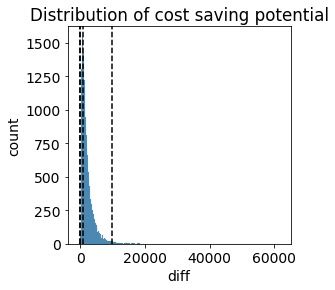

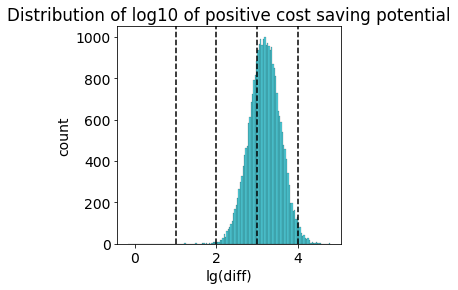

POSITIVES mean: 3.182, std: 0.385


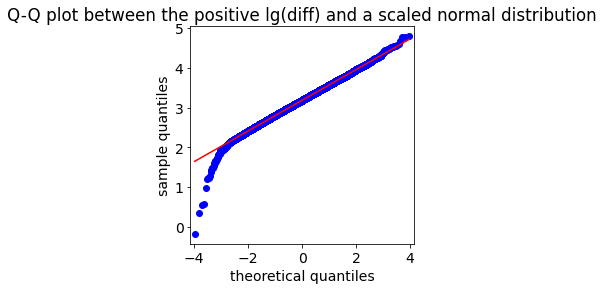

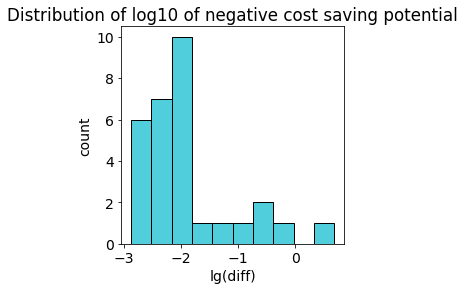

NEGATIVES mean: -1.903, std: 0.837


In [10]:
figsize_diff_dist = (4,4)
regular_df = bt_df.loc[~(bt_df['diff'].isnull()) & ~(np.isinf(bt_df["diff"]))]
regular_diff = bt_df.loc[~(bt_df['diff'].isnull()) & ~(np.isinf(bt_df["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

print(f"Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns {bt_df.shape[0]-regular_diff.shape[0]} instances.")
print(f"Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns {neg_diff.shape[0]} instances.")


plt.figure(figsize=figsize_diff_dist)
sns.histplot(data=regular_diff)
plt.ylabel("count")
plt.axvline(10, color="black", linestyle="--")
plt.axvline(100, color="black", linestyle="--")
plt.axvline(1000, color="black", linestyle="--")
plt.axvline(10000, color="black", linestyle="--")
plt.title("Distribution of cost saving potential")
plt.show()


plt.figure(figsize=figsize_diff_dist)
sns.histplot(data=log_pos_diff, color="tab:cyan")
plt.ylabel("count")
plt.axvline(1, color="black", linestyle="--")
plt.axvline(2, color="black", linestyle="--")
plt.axvline(3, color="black", linestyle="--")
plt.axvline(4, color="black", linestyle="--")
plt.xlabel("lg(diff)")
plt.title("Distribution of log10 of positive cost saving potential")
plt.show()
print(f"POSITIVES mean: {log_pos_diff.mean():0.3f}, std: {log_pos_diff.std():0.3f}")


fig = plt.figure(figsize=figsize_diff_dist)
ax = fig.add_subplot(111)
sm.qqplot(log_pos_diff, line='s', ax=ax) # line='45'
plt.title(label="")
plt.ylabel('sample quantiles')
plt.xlabel('theoretical quantiles')
plt.title("Q-Q plot between the positive lg(diff) and a scaled normal distribution")
plt.show()


plt.figure(figsize=figsize_diff_dist)
sns.histplot(data=log_neg_diff, color="tab:cyan")
plt.ylabel("count")
plt.xlabel("lg(diff)")
plt.title("Distribution of log10 of negative cost saving potential")
plt.show()
print(f"NEGATIVES mean: {log_neg_diff.mean():0.3f}, std: {log_neg_diff.std():0.3f}")

In [11]:
print("regular diff distribution")
print(f"x <= 0:            {(regular_diff<=0).sum()}")
print(f"0 < x <= 10:       {((regular_diff>0) & (regular_diff<=10)).sum()}")
print(f"10 < x <= 100:     {((regular_diff>10) & (regular_diff<=100)).sum()}")
print(f"100 < x <= 1000:   {((regular_diff>100) & (regular_diff<=1000)).sum()}")
print(f"1000 < x <= 10000: {((regular_diff>1000) & (regular_diff<=10000)).sum()}")
print(f"10000 < x:         {(regular_diff>10000).sum()}")
print("regular diff distribution normed")
print(f"x <= 0:            {(regular_diff<=0).sum()/regular_diff.shape[0]}")
print(f"0 < x <= 10:       {((regular_diff>0) & (regular_diff<=10)).sum()/regular_diff.shape[0]}")
print(f"10 < x <= 100:     {((regular_diff>10) & (regular_diff<=100)).sum()/regular_diff.shape[0]}")
print(f"100 < x <= 1000:   {((regular_diff>100) & (regular_diff<=1000)).sum()/regular_diff.shape[0]}")
print(f"1000 < x <= 10000: {((regular_diff>1000) & (regular_diff<=10000)).sum()/regular_diff.shape[0]}")
print(f"10000 < x:         {(regular_diff>10000).sum()/regular_diff.shape[0]}")

regular diff distribution
x <= 0:            30
0 < x <= 10:       5
10 < x <= 100:     58
100 < x <= 1000:   8938
1000 < x <= 10000: 19332
10000 < x:         458
regular diff distribution normed
x <= 0:            0.0010409076714895389
0 < x <= 10:       0.00017348461191492315
10 < x <= 100:     0.0020124214982131087
100 < x <= 1000:   0.3101210922591166
1000 < x <= 10000: 0.6707609035078589
10000 < x:         0.01589119045140696


In [12]:
print("counts")
print(f"regular instances: {regular_diff.shape[0]}")
print(f"+inf instances:    {bt_df.loc[(bt_df['diff'] > 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]}")
print(f"-inf instances:    {bt_df.loc[(bt_df['diff'] < 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]}")
print(f"NaN instances:     {bt_df.loc[(bt_df['diff'].isnull()), 'diff'].shape[0]}")
print("shares")
print(f"share regular instances: {regular_diff.shape[0]/bt_df.shape[0]}")
print(f"share +inf instances:    {bt_df.loc[(bt_df['diff'] > 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]/bt_df.shape[0]}")
print(f"share -inf instances:    {bt_df.loc[(bt_df['diff'] < 0) & (np.isinf(bt_df['diff'])), 'diff'].shape[0]/bt_df.shape[0]}")
print(f"share NaN instances:     {bt_df.loc[(bt_df['diff'].isnull()), 'diff'].shape[0]/bt_df.shape[0]}")

counts
regular instances: 28821
+inf instances:    583
-inf instances:    11521
NaN instances:     12075
shares
share regular instances: 0.5437924528301887
share +inf instances:    0.011
share -inf instances:    0.21737735849056602
share NaN instances:     0.2278301886792453


## Distribution of dependent variable: cost saving potential

To even out the class imbalance, the classes _negligible_ and _small_ are included into _medium_ by the next cell

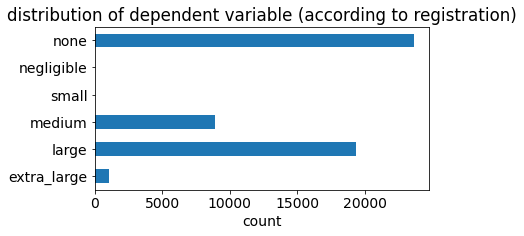

Original potential class distribution:
 none           23626
negligible         5
small             58
medium          8938
large          19332
extra_large     1041
Name: potential, dtype: int64 


Original potential class distribution normed:
 none           0.445774
negligible     0.000094
small          0.001094
medium         0.168642
large          0.364755
extra_large    0.019642
Name: potential, dtype: float64 




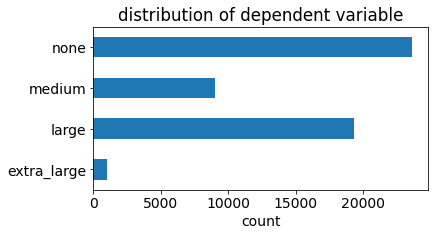

Condensed potential class distribution:
 none           23626
medium          9001
large          19332
extra_large     1041
Name: potential, dtype: int64 


Original potential class distribution normed:
 none           0.445774
medium         0.169830
large          0.364755
extra_large    0.019642
Name: potential, dtype: float64 




In [13]:
original_classes = ['none','negligible','small','medium','large','extra_large']
plt.figure(figsize=(6,3))
bt_df['potential'].value_counts()[original_classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.title("distribution of dependent variable (according to registration)")
plt.show()
print(f"Original potential class distribution:\n",bt_df['potential'].value_counts()[original_classes], "\n\n")
print(f"Original potential class distribution normed:\n",(bt_df['potential'].value_counts()/bt_df.shape[0])[original_classes], "\n\n")

# include 'negligible' and 'small' into 'medium'
bt_df.loc[bt_df['potential'] == 'negligible', 'potential'] = "medium"
bt_df.loc[bt_df['potential'] == 'small', 'potential'] = "medium"

classes = ['none','medium','large','extra_large']
plt.figure(figsize=(6,3))
bt_df['potential'].value_counts()[classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.title("distribution of dependent variable")
plt.show()
print(f"Condensed potential class distribution:\n",bt_df['potential'].value_counts()[classes], "\n\n")
print(f"Original potential class distribution normed:\n",(bt_df['potential'].value_counts()/bt_df.shape[0])[classes], "\n\n")

### Distribution of independent and confounding variables

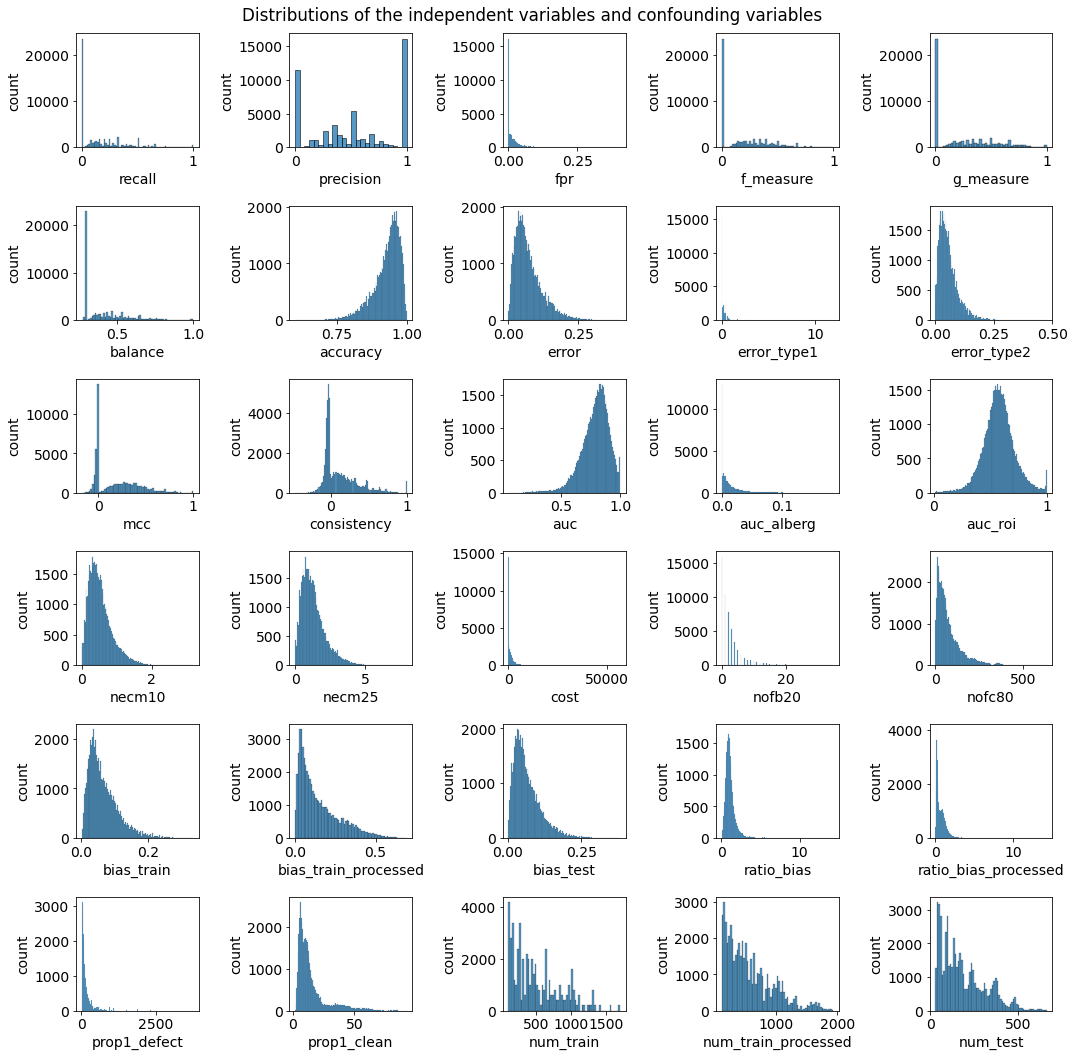

In [14]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))

feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(bt_df, x=bt_df.columns[feature_index], ax=col)
        col.set_ylabel("count")
        feature_index += 1
        
fig.suptitle("Distributions of the independent variables and confounding variables")
plt.tight_layout()
plt.show()

#### Log distribution of independent and confounding variables


NOTE: For computational reasons all 0 values in this plot are replaced with 1e-3.


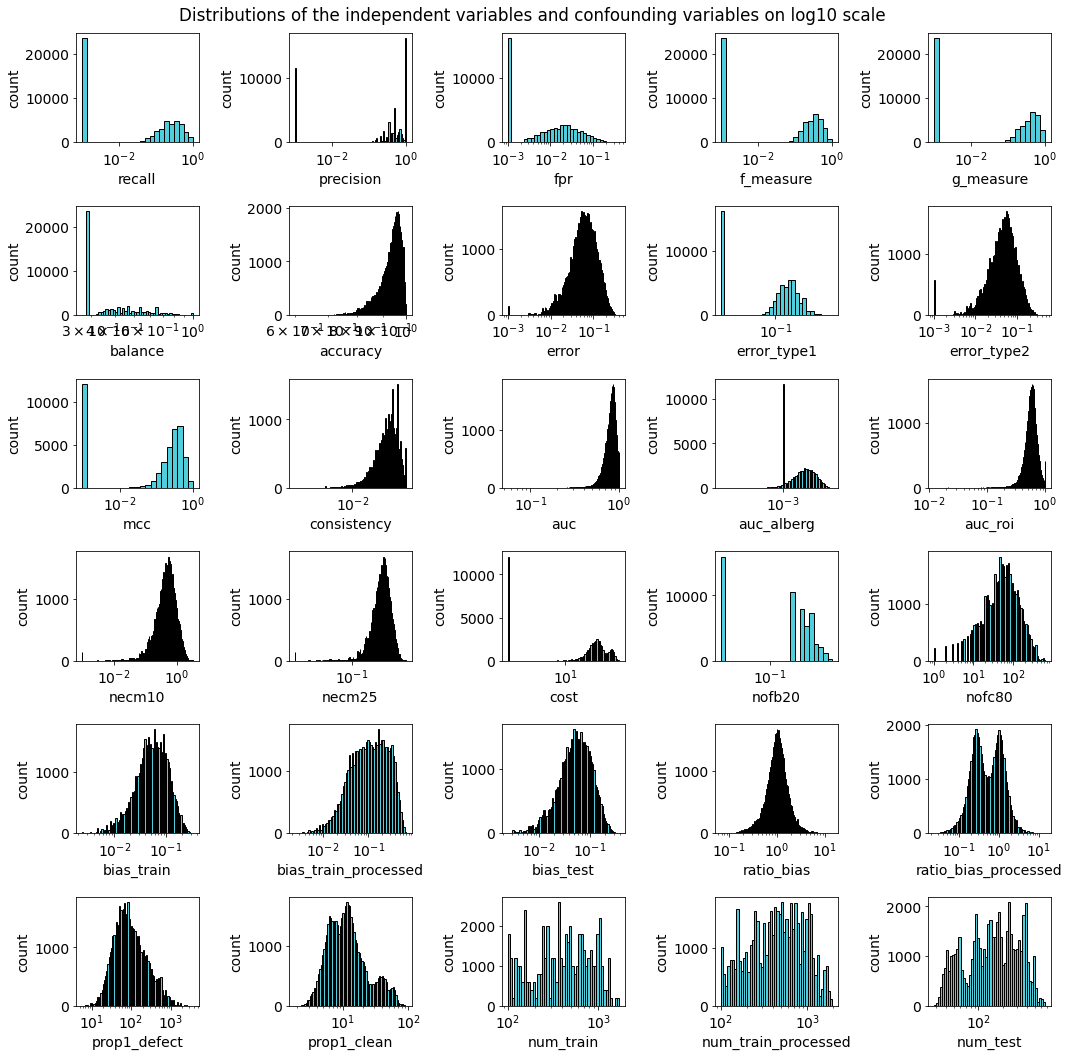

In [15]:
bt_df_4_log = bt_df.copy(deep=True)
bt_df_4_log.replace(to_replace=0, value=0.001, inplace=True)
print("NOTE: For computational reasons all 0 values in this plot are replaced with 1e-3.")

fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(bt_df_4_log, x=bt_df_4_log.columns[feature_index], color="tab:cyan", ax=col, log_scale=True)
        col.set_xlabel(bt_df_4_log.columns[feature_index])
        col.set_ylabel("count")
        feature_index += 1

fig.suptitle("Distributions of the independent variables and confounding variables on log10 scale")
plt.tight_layout()
plt.show()

### Influence of preprocessing (SMOTUNED)

median bias from the instances processed with SMOTUNED: 0.216


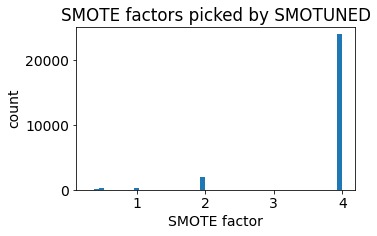

4.0    23992
2.0     1951
1.0      233
0.5      220
0.4       81
0.3       23
Name: smote, dtype: int64

In [16]:
df_s= bt_df.loc[bt_df["configuration"] == "Smotuned"]
print(f"median bias from the instances processed with SMOTUNED: {df_s['bias_train_processed'].median():0.3f}")
df_s = df_s[["bias_train", "bias_train_processed", "num_train", "num_train_processed", "ratio_bias", "ratio_bias_processed"]]
df_s["bugs"] = df_s["bias_train"] * df_s["num_train"]
df_s["bugs_s"] = df_s["bias_train_processed"] * df_s["num_train_processed"]
df_s["smote"] = df_s["bugs_s"] / df_s["bugs"] - 1  # get the smote factor
df_s["smote"]=df_s["smote"].round(decimals=1)

plt.figure(figsize=(5,3))
df_s["smote"].plot.hist(bins=50)
plt.ylabel("count")
plt.xlabel("SMOTE factor")
plt.title("SMOTE factors picked by SMOTUNED")
plt.show()

df_s["smote"].value_counts(sort=True)

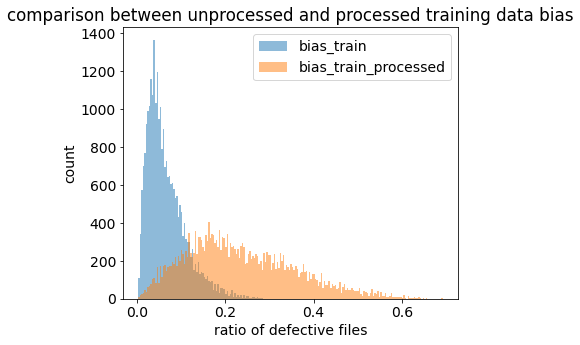

In [17]:
df_s[["bias_train", "bias_train_processed"]].plot(kind="hist", alpha=0.5, bins=200, figsize=(6,5))
plt.xlabel("ratio of defective files")
plt.ylabel("count")
plt.title("comparison between unprocessed and processed training data bias")
plt.show()

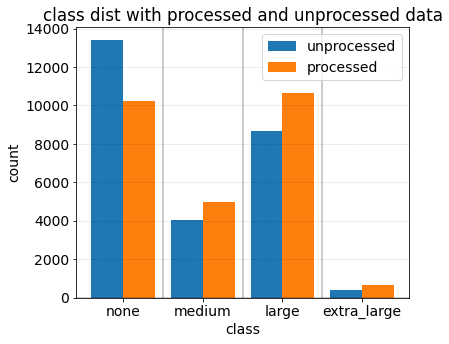

In [18]:
counts_unprocessed = bt_df.loc[~ (bt_df["configuration"]=="Smotuned")]['potential'].value_counts()[classes]
counts_processed = bt_df.loc[bt_df["configuration"]=="Smotuned"]['potential'].value_counts()[classes]
plot_data = np.asarray((counts_unprocessed,counts_processed))

bar_plot_wrapper(plot_data.T, classes, data_std=None, set_labels=["unprocessed","processed"], title="class dist with processed and unprocessed data",
                 xlabel="class", ylabel="count", figsize=(6, 5), rotate_ticks=False)

### Overall correlation Matrix
Spearman-rank correlation between all the independent and confounding variables

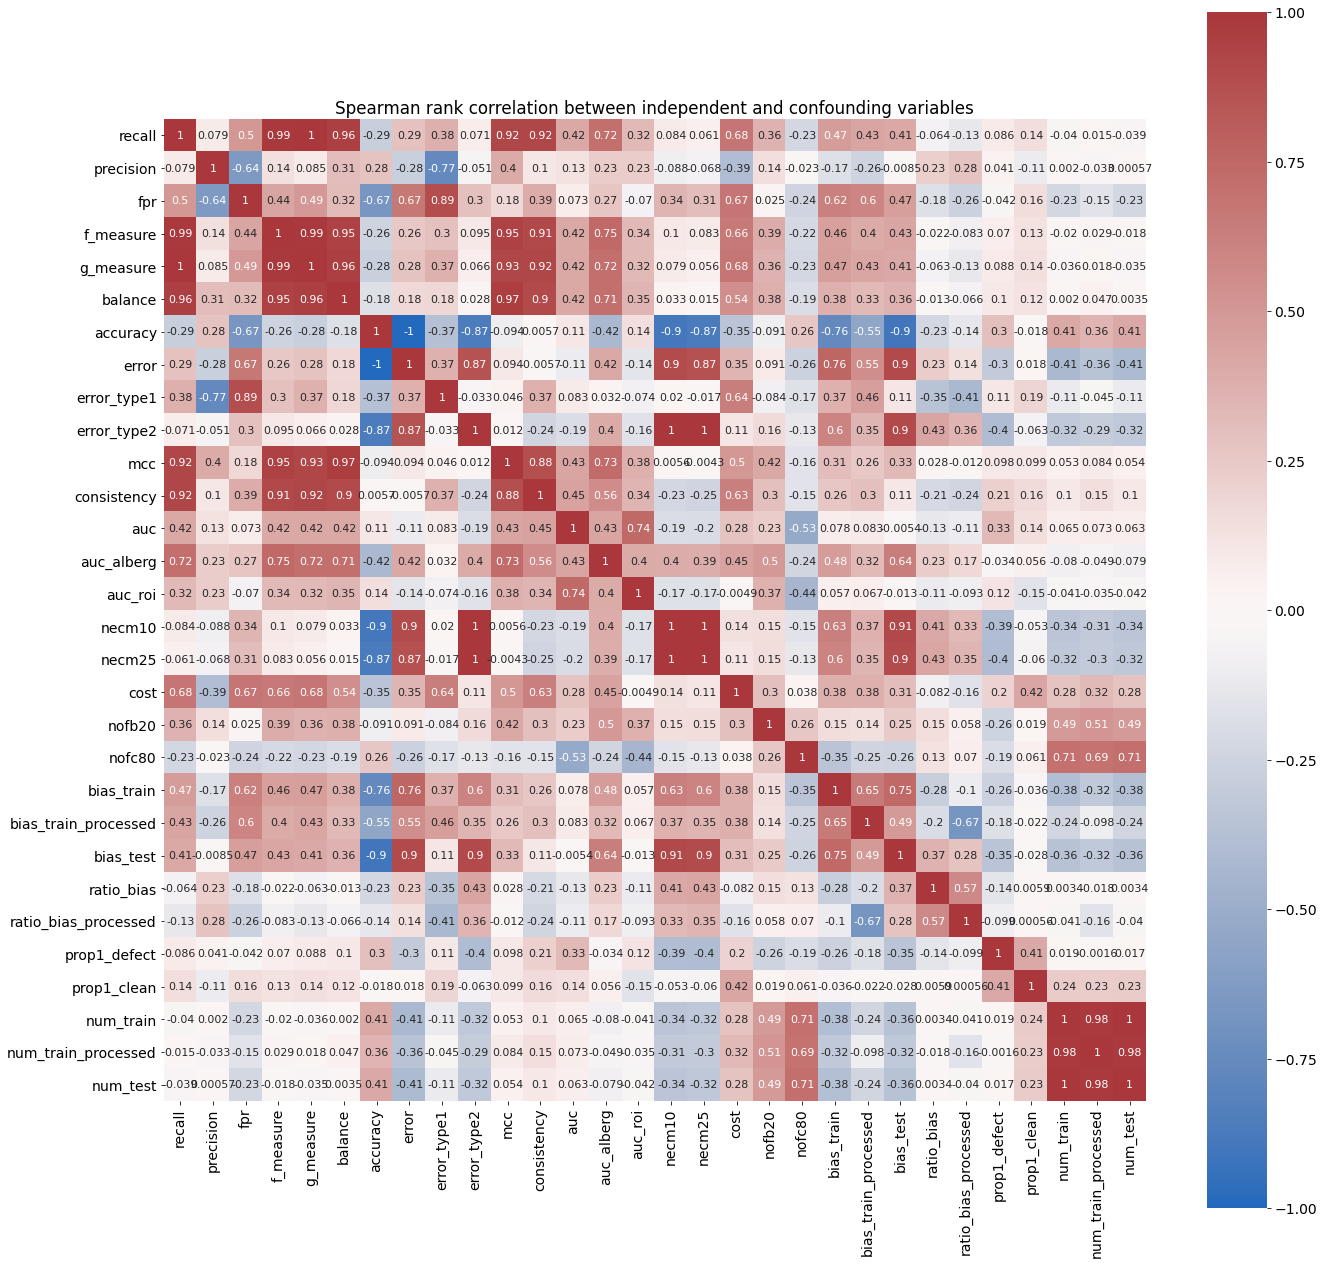

In [19]:
df_numeric = bt_df.iloc[:,FIRST_NUM_FEATURE_IDX:FIRST_NUM_FEATURE_IDX+30]
overall_spearman_corr_map = spearmanr(a=df_numeric).correlation

plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map, square=True, annot=True, xticklabels=df_numeric.columns,
                 yticklabels=df_numeric.columns, cmap="vlag", annot_kws={"size": heatmap_fontsize})

plt.title("Spearman rank correlation between independent and confounding variables")
plt.show()

### Variables vs lg(diff)

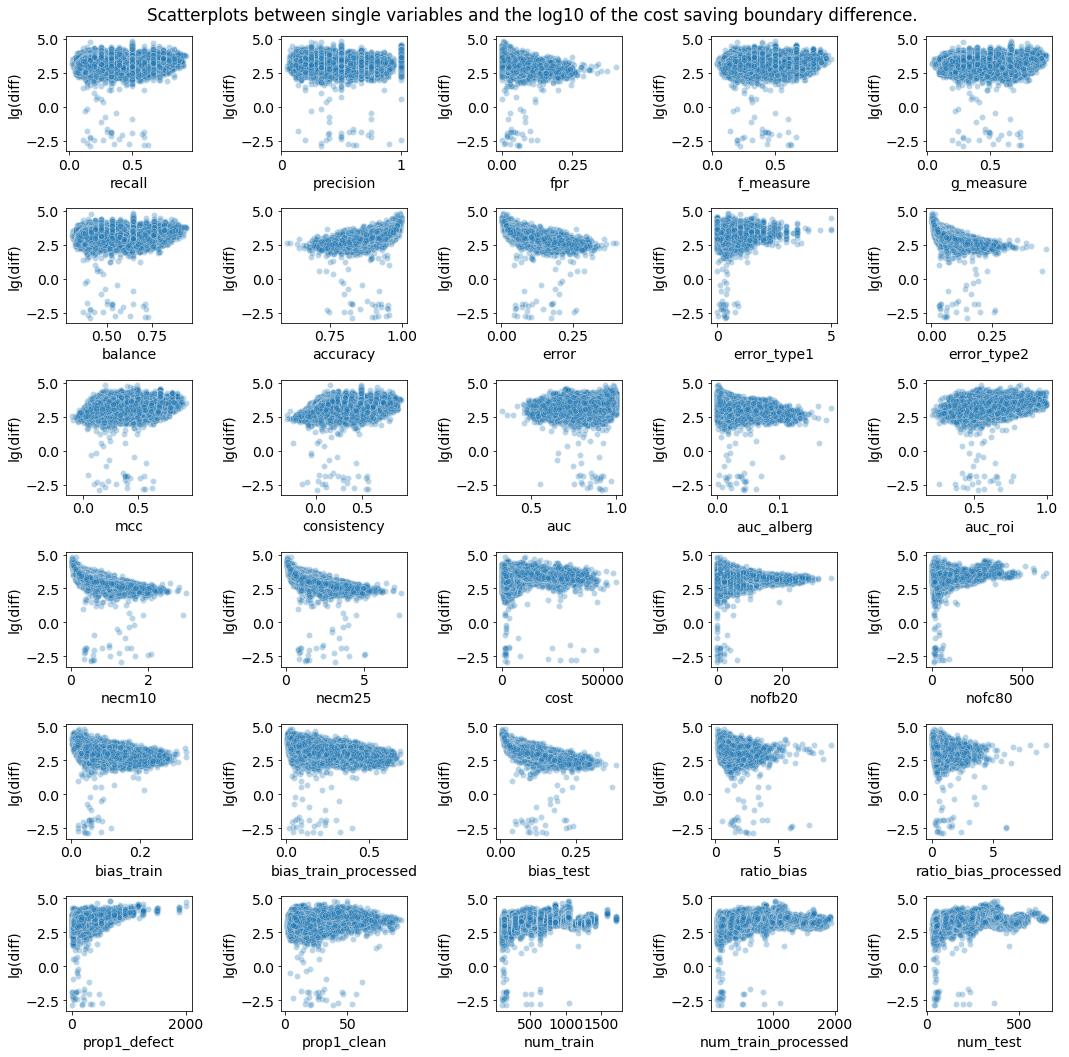

In [20]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.scatterplot(x=bt_df.iloc[:,feature_index], y=log_diff, ax=col, alpha=0.3)
        col.set_ylabel("lg(diff)")
        feature_index += 1
        
fig.suptitle("Scatterplots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()

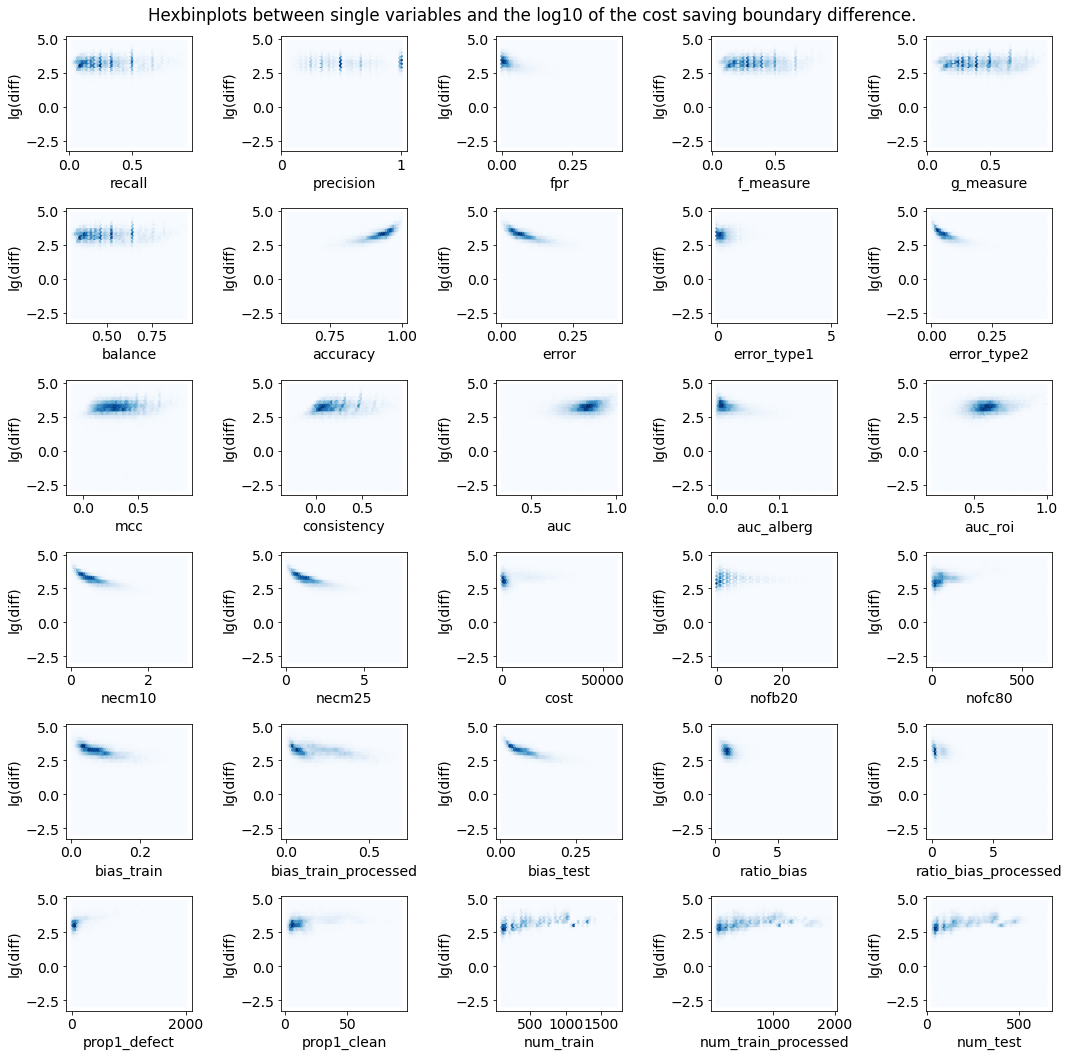

In [21]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        hb = col.hexbin(x=regular_df.iloc[:,feature_index], y=log_diff, gridsize=50, cmap='Blues')
        col.set_ylabel("lg(diff)")
        col.set_xlabel(regular_df.columns[feature_index])
        feature_index += 1
        
fig.suptitle("Hexbinplots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()

### Sensitivity Analysis

In [22]:
region_medium_large = bt_df.loc[(bt_df["diff"]>900) & (bt_df["diff"]<1100)].shape[0]
print(f"Elements in boundary region medium-large [900,1100]: {region_medium_large}")
print(f"{100* region_medium_large / bt_df['potential'].value_counts()['medium']:0.1f}% of medium "
      f"and {100* region_medium_large / bt_df['potential'].value_counts()['large']:0.1f}% of large")
print()
region_large_extralarge = bt_df.loc[(bt_df["diff"]>9000) & (bt_df["diff"]<11000)].shape[0]
print(f"Instances in boundary region large-extra_large [9000,11000]: {region_large_extralarge}")
print(f"{100* region_large_extralarge / bt_df['potential'].value_counts()['large']:0.1f}% of large "
      f"and {100* region_large_extralarge / bt_df['potential'].value_counts()['extra_large']:0.1f}% of extra_large")

Elements in boundary region medium-large [900,1100]: 2338
26.0% of medium and 12.1% of large

Instances in boundary region large-extra_large [9000,11000]: 300
1.6% of large and 28.8% of extra_large


In [23]:
donwshift_conditions = [
    (bt_df['diff'] <= 0) | (bt_df['diff'] == -np.inf) | (bt_df['diff'].isnull()),
    (bt_df['diff'] > 0) & (bt_df['diff'] <= 900),
    (bt_df['diff'] > 900) & (bt_df['diff'] <= 9000),
    (bt_df['diff'] > 9000 | (bt_df['diff'] == np.inf))
    ]
upshift_conditions = [
    (bt_df['diff'] <= 0) | (bt_df['diff'] == -np.inf) | (bt_df['diff'].isnull()),
    (bt_df['diff'] > 0) & (bt_df['diff'] <= 1100),
    (bt_df['diff'] > 1100) & (bt_df['diff'] <= 11000),
    (bt_df['diff'] > 11000 | (bt_df['diff'] == np.inf))
    ]

bt_df['downshift_potential'] = np.select(donwshift_conditions, classes)
bt_df['upshift_potential'] = np.select(upshift_conditions, classes)


# Evaluation Models

### Preprocessing
 - apply feature scaling
 - split dataset

In [24]:
df_features = bt_df.drop(['release', 'configuration', 'diff','potential','downshift_potential', "upshift_potential"], axis = 1)

y = bt_df['potential']
downshift_y = bt_df['downshift_potential']
upshift_y = bt_df['upshift_potential']

X_unnormed = df_features
Xmax = X_unnormed.max()
Xmin = X_unnormed.min()
X = (X_unnormed - Xmin)/(Xmax - Xmin)

In [25]:
train_df = X.copy(deep=True)
train_df["target"] = y
train_df.to_csv(os.path.join(DATA_PATH, CSV_FILENAME_TRAINING_DATA), index=False)

## Logit model

In [26]:
if RERUN_LOGIT_OPTIMIZER:
    run_grid_search(os.path.join(DATA_PATH, CSV_FILENAME_TRAINING_DATA), os.path.join(DATA_PATH, CSV_FILENAME_LOGIT_OPTIM))

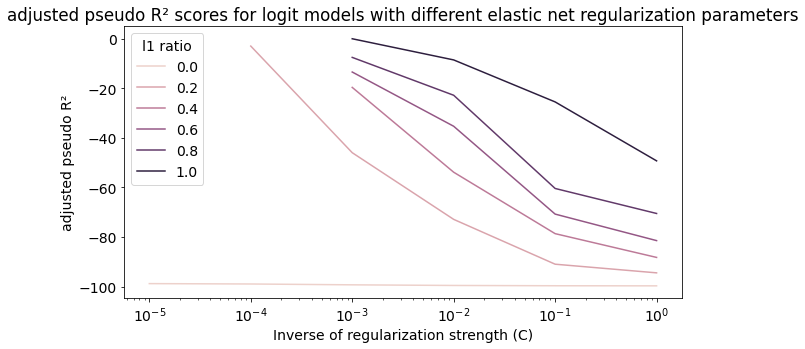

Best models sorted by adjusted pseudo R²:
         c   l1    adj_pR2  adj_weighted_pR2   num_coef
17  0.0010  1.0  -0.024225         -0.404701   2.000000
7   0.0001  0.2  -2.977725         -4.456351   6.000000
16  0.0010  0.8  -7.540520         -6.922228  11.000000
23  0.0100  1.0  -8.561387         -3.332073  11.666667
15  0.0010  0.6 -13.441811        -11.868748  18.000000




In [27]:
optim_df = pd.read_csv(os.path.join(DATA_PATH, CSV_FILENAME_LOGIT_OPTIM))
optim_df = optim_df.loc[optim_df['adj_pR2'] != -np.inf]

plt.figure(figsize=(10, 5))
sns.lineplot(data=optim_df, x="c", y="adj_pR2", hue="l1")
plt.xscale('log')
plt.legend(title="l1 ratio")
plt.xlabel("Inverse of regularization strength (C)")
plt.ylabel("adjusted pseudo R²")
plt.title("adjusted pseudo R² scores for logit models with different elastic net regularization parameters")
plt.show()

print("Best models sorted by adjusted pseudo R²:")
print(optim_df.loc[optim_df['adj_pR2'] != -np.inf].sort_values('adj_pR2',axis=0, ascending=False).head(5))
print("\n")

In [28]:
optim_logit_config = optim_df[optim_df['adj_pR2']==optim_df['adj_pR2'].max()]
print(f"The picked model hyperparameters are a regulation strength of {optim_logit_config.c.values[0]} and a l1-ratio of {optim_logit_config.l1.values[0]} .")

The picked model hyperparameters are a regulation strength of 0.001 and a l1-ratio of 1.0 .


name             LogisticRegression
training t.                0.821317
prediction t.              0.014296
recall                     0.500484
precision                   0.63098
accuracy                   0.790717
F1 measure                 0.476058
MCC                        0.675043
dtype: object


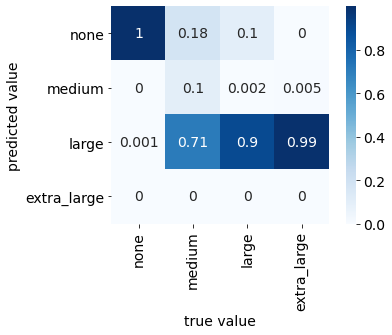

                              none    medium     large  extra_large
correctly_predicted       0.998815  0.104766  0.898355     0.000000
moderate_overprediction   0.000254  0.711921  0.000000          NaN
overall_overprediction    0.001185  0.711921  0.000000          NaN
moderate_underprediction       NaN  0.183313  0.001655     0.995197
overall_underprediction        NaN  0.183313  0.101645     1.000000


In [29]:
model_lr = LogisticRegression(penalty="elasticnet", solver="saga", C=optim_logit_config.c.values[0], l1_ratio=optim_logit_config.l1.values[0],
                              fit_intercept=True, random_state=RANDOM_STATE, max_iter=10000)
_, metrics_df = run_model(model_lr, "LogisticRegression", X, y, X, y, metrics_df, classes)

In [30]:
sorted_coef = resort_coef(model_lr.coef_, model_lr.classes_, classes)
sorted_intercept = resort_coef(model_lr.intercept_, model_lr.classes_, classes)

intercept_and_coef = np.insert(sorted_coef.T, 0, sorted_intercept, axis=0).T
coef_labels = X.columns.to_list()
coef_labels.insert(0, "intercept")

print('Coefficients')
pd.DataFrame(intercept_and_coef, columns=coef_labels)

Coefficients


intercept  recall  precision  fpr  f_measure  g_measure  balance  accuracy  \
0   2.500509     0.0        0.0  0.0        0.0  -9.629102      0.0  0.000000   
1  -0.408784     0.0        0.0  0.0        0.0   0.000000      0.0 -0.001484   
2   0.193906     0.0        0.0  0.0        0.0   0.000000      0.0  0.000000   
3  -2.285632     0.0        0.0  0.0        0.0   0.000000      0.0  0.000000   

      error  error_type1  error_type2  mcc  consistency  auc  auc_alberg  \
0  0.000000          0.0          0.0  0.0          0.0  0.0         0.0   
1  0.000018          0.0          0.0  0.0          0.0  0.0         0.0   
2  0.000000          0.0          0.0  0.0          0.0  0.0         0.0   
3  0.000000          0.0          0.0  0.0          0.0  0.0         0.0   

   auc_roi  necm10  necm25  cost  nofb20  nofc80  bias_train  \
0      0.0     0.0     0.0   0.0     0.0     0.0         0.0   
1      0.0     0.0     0.0   0.0     0.0     0.0         0.0   
2      0.0     0.0     0.0   0.0     0.0     0.0         0.0   
3      0.0     0.0     0.0   0.0     0.0     0.0         0.0   

   bias_train_processed  bias_test  ratio_bias  ratio_bias_processed  \
0                   0.0   0.000000         0.0                   0.0   
1                   0.0   1.324528         0.0                   0.0   
2                   0.0   0.000000         0.0                   0.0   
3                   0.0   0.000000         0.0                   0.0   

   prop1_defect  prop1_clean  num_train  num_train_processed  num_test  
0           0.0          0.0   0.000000             0.000000  0.000000  
1           0.0          0.0   0.000000             0.000000  0.000000  
2           0.0          0.0   1.722862             0.000779  0.000163  
3           0.0          0.0   0.000000             0.000000  0.000000

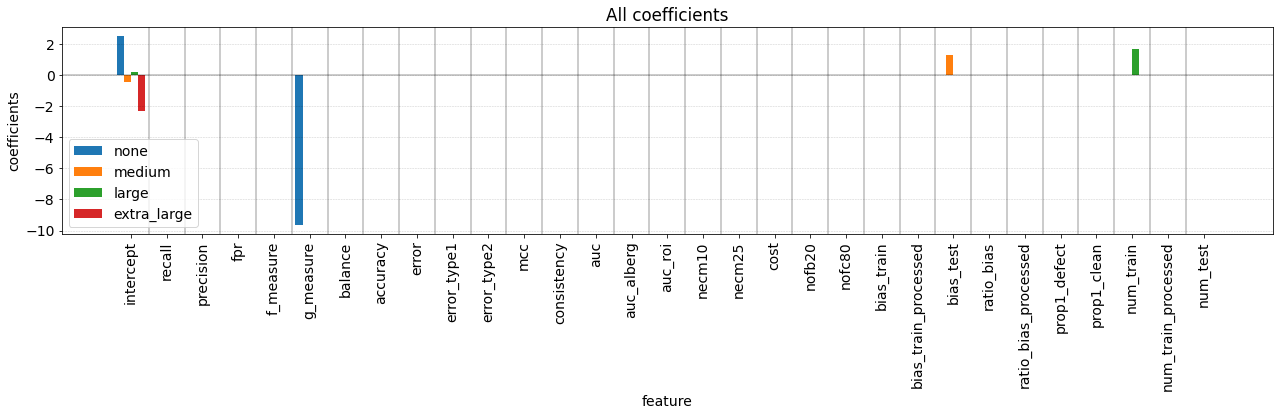

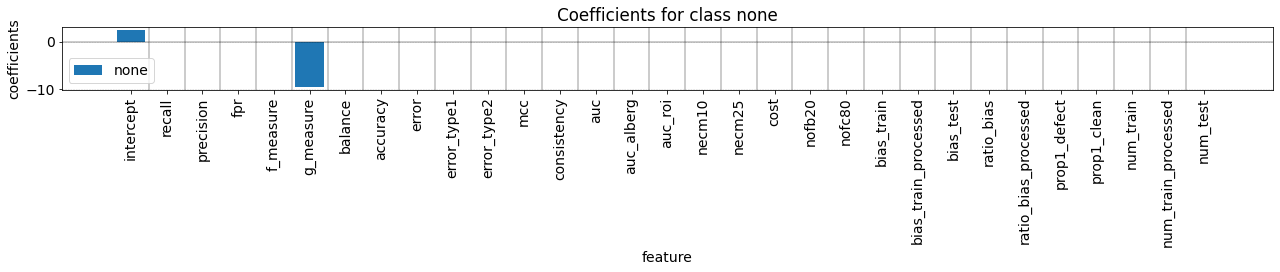

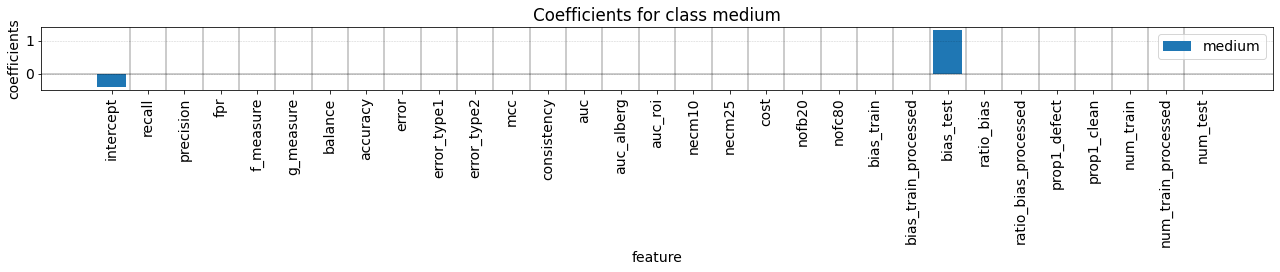

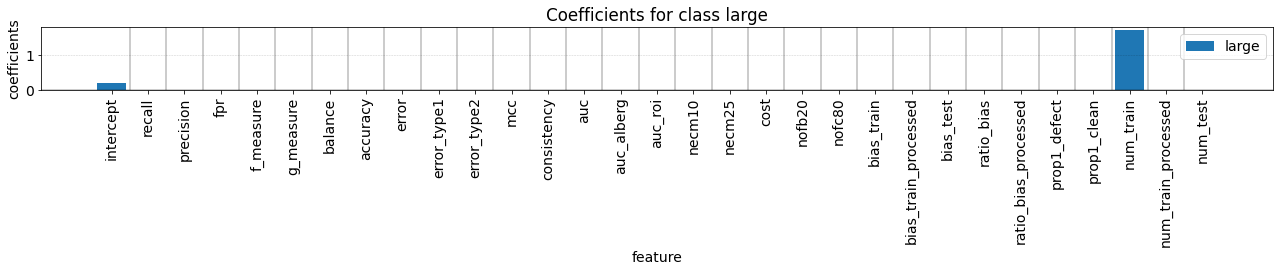

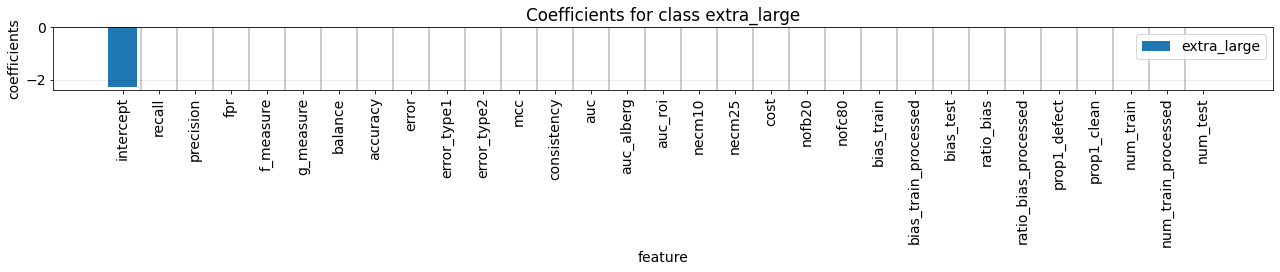

In [31]:
bar_plot_wrapper(intercept_and_coef.T, x_labels=coef_labels, data_std=None, set_labels=classes, figsize=(18,6), rotate_ticks=True, title=f"All coefficients")

for c, l in zip(intercept_and_coef, classes):
    c = c.reshape((c.shape[0],1))
    bar_plot_wrapper(c, x_labels=coef_labels, data_std=None, set_labels=[l], figsize=(18,4), rotate_ticks=True, title=f"Coefficients for class {l}")

Training model with only selected coefficeints g_measure, bias_test, and num_train without regularization and normalization
name             LogisticRegression
training t.               46.845188
prediction t.              0.002764
recall                     0.582272
precision                  0.588695
accuracy                   0.819075
F1 measure                 0.583126
MCC                        0.712153
dtype: object


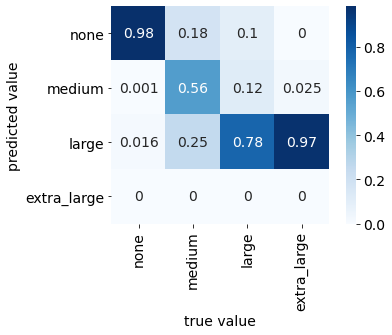

                              none    medium     large  extra_large
correctly_predicted       0.983366  0.565048  0.780675     0.000000
moderate_overprediction   0.000931  0.254416  0.000000          NaN
overall_overprediction    0.016634  0.254416  0.000000          NaN
moderate_underprediction       NaN  0.180535  0.119388     0.975024
overall_underprediction        NaN  0.180535  0.219325     1.000000


In [32]:
print("Training model with only selected coefficeints g_measure, bias_test, and num_train without regularization and normalization")
model_lr = LogisticRegression(penalty='none', solver="saga", fit_intercept=True, random_state=RANDOM_STATE, max_iter=10000)
_, metrics_df = run_model(model_lr, "LogisticRegression", X_unnormed[['g_measure', 'bias_test', 'num_train']], y, X_unnormed[['g_measure',  'bias_test', 'num_train']], y, metrics_df, classes)

## Decision tree model

name             DecisionTree
training t.          0.345682
prediction t.         0.00604
recall               0.856248
precision            0.914292
accuracy             0.924283
F1 measure           0.879277
MCC                  0.881885
dtype: object


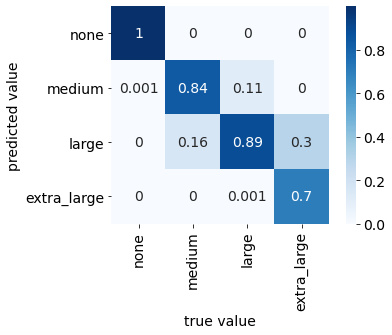

                              none    medium     large  extra_large
correctly_predicted       0.998730  0.837463  0.885630      0.70317
moderate_overprediction   0.000931  0.162537  0.000828          NaN
overall_overprediction    0.001270  0.162537  0.000828          NaN
moderate_underprediction       NaN  0.000000  0.113542      0.29683
overall_underprediction        NaN  0.000000  0.113542      0.29683

 Text Representation of the Tree:
|--- recall <= 0.010
|   |--- class: none
|--- recall >  0.010
|   |--- accuracy <= 0.898
|   |   |--- num_train <= 527.500
|   |   |   |--- error_type2 <= 0.049
|   |   |   |   |--- consistency <= 0.944
|   |   |   |   |   |--- class: large
|   |   |   |   |--- consistency >  0.944
|   |   |   |   |   |--- class: extra_large
|   |   |   |--- error_type2 >  0.049
|   |   |   |   |--- bias_test <= 0.099
|   |   |   |   |   |--- class: medium
|   |   |   |   |--- bias_test >  0.099
|   |   |   |   |   |--- class: medium
|   |   |--- num_train >  527.500

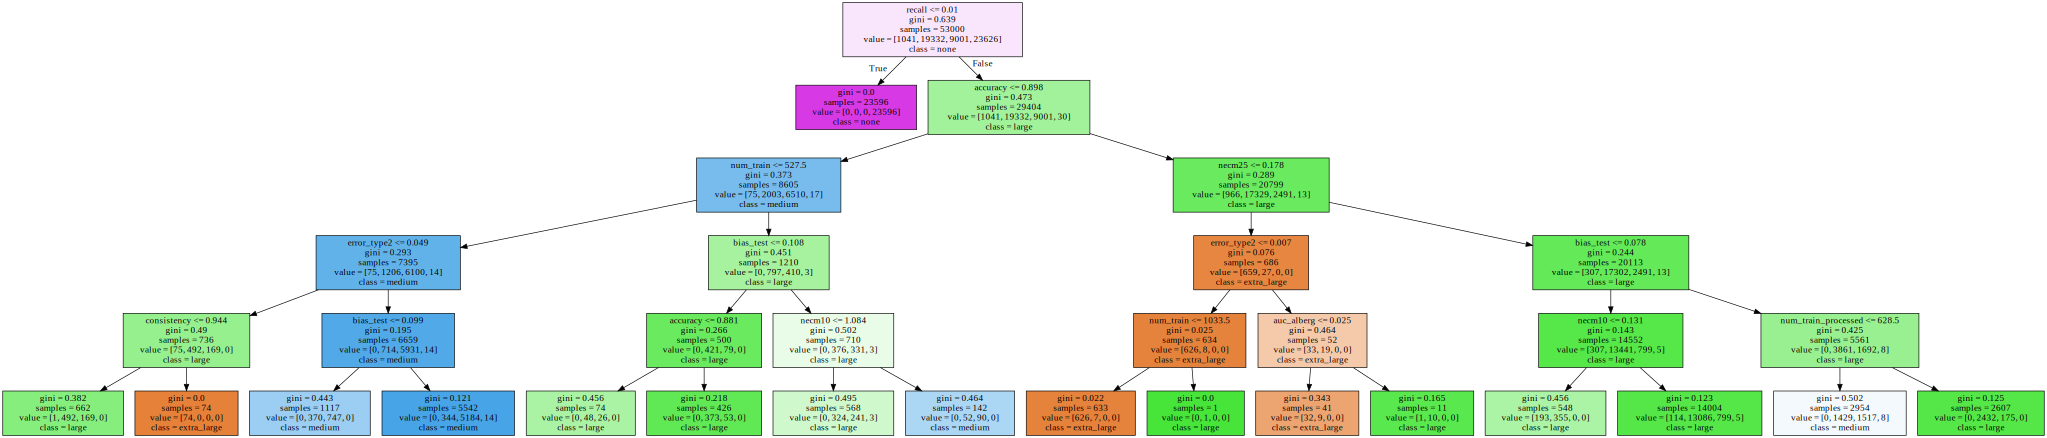

In [33]:
model_dt = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=RANDOM_STATE)
_, metrics_df = run_model(model_dt, "DecisionTree",X_unnormed, y, X_unnormed, y, metrics_df, classes)

# 1 - PRINT TEXT REPRESENTATION
print("\n Text Representation of the Tree:")
text_representation = tree.export_text(model_dt,
                                       feature_names=X_unnormed.columns.tolist(),
                                       decimals=3)

print(text_representation)

# 2 - USE GRAPHVIZ
print("decision tree graphic:")
tree.export_graphviz(model_dt,
                     out_file=os.path.join(PLOTS_DIR, 'decision_tree.dot'),
                     feature_names = X_unnormed.columns, 
                     class_names=model_dt.classes_,
                     filled = True)
dot_data = tree.export_graphviz(model_dt,
                     feature_names = X_unnormed.columns, 
                     class_names=model_dt.classes_,
                     filled = True)

#! dot -Tpdf tree.dot -o tree.pdf
os.system(f"dot -Tpdf {os.path.join(PLOTS_DIR, 'decision_tree.dot')} -o {os.path.join(PLOTS_DIR, 'decision_tree.pdf')}")

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

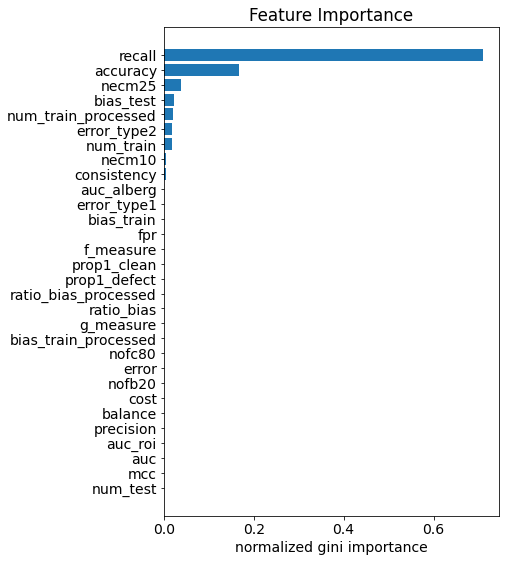

feature  importance
0                recall    0.709131
6              accuracy    0.166125
16               necm25    0.037295
22            bias_test    0.023213
28  num_train_processed    0.019724
9           error_type2    0.018371
27            num_train    0.017869
15               necm10    0.004162
11          consistency    0.003817
13           auc_alberg    0.000293

In [34]:
dt_feature_importance = model_dt.tree_.compute_feature_importances(normalize=True)

dt_feat_importance_dict = {'feature': X.columns,
                      'importance': dt_feature_importance}
dt_feat_importance_df = pd.DataFrame(dt_feat_importance_dict)
dt_feat_importance_df.sort_values("importance", axis=0, ascending=False, inplace=True)


plt.figure(figsize=(6,9))
plt.barh(dt_feat_importance_df["feature"], dt_feat_importance_df["importance"])
plt.xlabel("normalized gini importance")
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()

dt_feat_importance_df.loc[dt_feat_importance_df['importance'] != 0]

## Random forest model

In [35]:
def rf_optimizer_function(x, *train_data):
    """compute loss (-MCC) for Random Forest model with specific set of hyperparameters."""
    X_training, y_training = train_data
    
    min_samples_leaf = int(x[0])
    min_samples_split = int(x[1])
    max_features = x[2]
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
                                   max_features=max_features, n_jobs=-1, random_state=RANDOM_STATE)
    mcc_scorer = make_scorer(matthews_corrcoef)
    mcc_scores =cross_val_score(model, X_training, y_training, cv=3, scoring=mcc_scorer)
    return -1 * mcc_scores.mean()

t0 = time.time()
bounds = [(1,21), (2,21), (0.000001, 1.0)]
result_rf = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=RANDOM_STATE,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001, args=(X_unnormed, y))
print(result_rf)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf.x[0])
min_s_split = int(result_rf.x[1])
max_f = result_rf.x[2]

differential_evolution step 1: f(x)= -0.901631
differential_evolution step 2: f(x)= -0.902147
differential_evolution step 3: f(x)= -0.902147
     fun: -0.902147360501262
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([ 4.38985493, 20.06357182,  0.55680171])
time needed: 849.7783317565918


Tuned hyperparameters:
min_samples_leaf: 4	min_samples_split: 20	max_features: 0.5568017056570876
name             TunedRandomForest
training t.              10.984343
prediction t.             0.126209
recall                    0.940783
precision                 0.966838
accuracy                  0.972283
F1 measure                0.953108
MCC                       0.956578
dtype: object


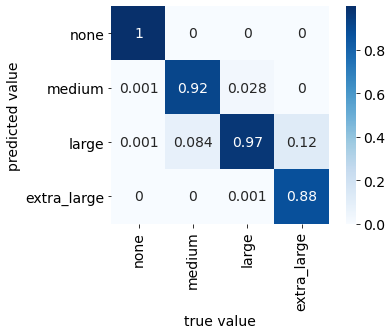

                             none   medium     large  extra_large
correctly_predicted       0.99873  0.91612  0.971239     0.877041
moderate_overprediction   0.00072  0.08388  0.001190          NaN
overall_overprediction    0.00127  0.08388  0.001190          NaN
moderate_underprediction      NaN  0.00000  0.027571     0.122959
overall_underprediction       NaN  0.00000  0.027571     0.122959


In [36]:
print(f"Tuned hyperparameters:")
print(f"min_samples_leaf: {min_s_leaf}\tmin_samples_split: {min_s_split}\tmax_features: {max_f}")
model_rf = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=RANDOM_STATE)
_, metrics_df = run_model(model_rf, "TunedRandomForest",X_unnormed, y, X_unnormed, y, metrics_df, classes)

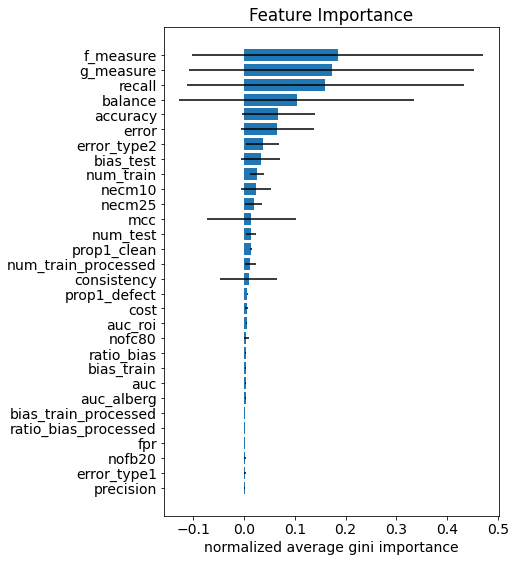

feature      mean       std
3              f_measure  0.184323  0.287062
4              g_measure  0.172560  0.281107
0                 recall  0.160293  0.272884
5                balance  0.103702  0.231576
6               accuracy  0.067608  0.072062
7                  error  0.065587  0.071637
9            error_type2  0.036695  0.032658
22             bias_test  0.032791  0.038760
27             num_train  0.025577  0.013403
15                necm10  0.023474  0.030073
16                necm25  0.018799  0.016320
10                   mcc  0.014519  0.087947
29              num_test  0.013376  0.009364
26           prop1_clean  0.013326  0.001582
28   num_train_processed  0.012694  0.010064
11           consistency  0.009220  0.055884
25          prop1_defect  0.006567  0.001416
17                  cost  0.005298  0.002967
14               auc_roi  0.005024  0.001020
19                nofc80  0.004840  0.004558
23            ratio_bias  0.003693  0.000885
20            bias_train  0.003278  0.000870
12                   auc  0.003065  0.000664
13            auc_alberg  0.003023  0.000987
21  bias_train_processed  0.002314  0.000655
24  ratio_bias_processed  0.002222  0.000593
2                    fpr  0.001963  0.000777
18                nofb20  0.001697  0.002129
8            error_type1  0.001427  0.001565
1              precision  0.001042  0.000630

In [37]:
rf_feat_importance = model_rf.feature_importances_
rf_feat_importance_std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
rf_feat_importance_dict = {'feature': X.columns,
                      'mean': rf_feat_importance,
                          'std': rf_feat_importance_std}
rf_feat_importance_df = pd.DataFrame(rf_feat_importance_dict)
rf_feat_importance_df.sort_values("mean", axis=0, ascending=False, inplace=True)

plt.figure(figsize=(6,9))
plt.barh(rf_feat_importance_df["feature"], rf_feat_importance_df["mean"], xerr=rf_feat_importance_df["std"])
plt.xlabel("normalized average gini importance")
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()

rf_feat_importance_df.loc[rf_feat_importance_df['mean'] != 0]

### Sensitivity Analysis Random Forest Models

differential_evolution step 1: f(x)= -0.903073
differential_evolution step 2: f(x)= -0.903073
differential_evolution step 3: f(x)= -0.903073
     fun: -0.9030734808932794
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([ 9.63890037, 19.91421784,  0.59886587])
time needed: 1741.3662021160126
name             DownShiftRandomForest
training t.                   9.161613
prediction t.                 0.083919
recall                        0.929409
precision                     0.956639
accuracy                      0.968434
F1 measure                    0.942302
MCC                           0.949964
dtype: object


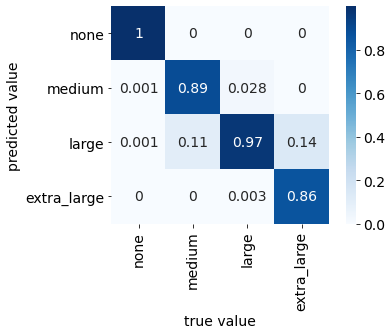

                             none    medium     large  extra_large
correctly_predicted       0.99873  0.890519  0.969834     0.858553
moderate_overprediction   0.00072  0.109481  0.002510          NaN
overall_overprediction    0.00127  0.109481  0.002510          NaN
moderate_underprediction      NaN  0.000000  0.027656     0.141447
overall_underprediction       NaN  0.000000  0.027656     0.141447
differential_evolution step 1: f(x)= -0.901011
differential_evolution step 2: f(x)= -0.901011
differential_evolution step 3: f(x)= -0.901011
     fun: -0.901011410911253
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([4.6680902 , 7.78060262, 0.52475691])
time needed: 2430.441695690155
name             UpShiftRandomForest
training t.                  8.65522
prediction t.               0.093246
recall                      0.968172
precision                   0.981805
accuracy                    0.984623
F1 measure          

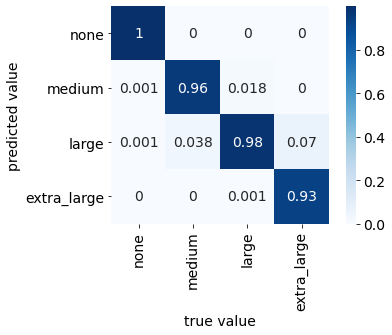

                              none    medium     large  extra_large
correctly_predicted       0.998773  0.962457  0.981405     0.930055
moderate_overprediction   0.000677  0.037543  0.000656          NaN
overall_overprediction    0.001227  0.037543  0.000656          NaN
moderate_underprediction       NaN  0.000000  0.017939     0.069945
overall_underprediction        NaN  0.000000  0.017939     0.069945


name  training t.  prediction t.    recall  precision  \
0      TunedRandomForest    10.984343       0.126209  0.940783   0.966838   
1  DownShiftRandomForest     9.161613       0.083919  0.929409   0.956639   
2    UpShiftRandomForest     8.655220       0.093246  0.968172   0.981805   

   accuracy  F1 measure       MCC  
0  0.972283    0.953108  0.956578  
1  0.968434    0.942302  0.949964  
2  0.984623    0.974780  0.976155

In [38]:
sensitivity_df = pd.DataFrame(columns=metrics_names)
sensitivity_df = sensitivity_df.append(metrics_df.loc[metrics_df['name']=='TunedRandomForest'])

result_rf_downshift = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=RANDOM_STATE,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001, args=(X_unnormed, downshift_y))
print(result_rf_downshift)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf_downshift.x[0])
min_s_split = int(result_rf_downshift.x[1])
max_f = result_rf_downshift.x[2]

downshift_model_rf = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=RANDOM_STATE)
_, sensitivity_df = run_model(downshift_model_rf, "DownShiftRandomForest", X_unnormed, downshift_y, X_unnormed, downshift_y, sensitivity_df, classes)

result_rf_upshift = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=RANDOM_STATE,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001, args=(X_unnormed, upshift_y))
print(result_rf_upshift)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf_upshift.x[0])
min_s_split = int(result_rf_upshift.x[1])
max_f = result_rf_upshift.x[2]

upshift_model_rf = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=RANDOM_STATE)
_, sensitivity_df = run_model(upshift_model_rf, "UpShiftRandomForest",X_unnormed, upshift_y, X_unnormed, upshift_y, sensitivity_df, classes)

sensitivity_df

# Generalization


In [39]:
general_approach_list = ['1_AsIs','2_Kawata15','3_Peters15','4_Canfora13','5_Watanabe08','6_CamargoCruz09']

rs_df = pd.read_csv(os.path.join(DATA_PATH, CSV_FILENAME_GENERALIZATION), index_col=0)
print(f"Shape of the dataset: {rs_df.shape}")

dataset_overview(rs_df)

Shape of the dataset: (1698, 34)
Number of releases: 337
Instances per release: [3, 6]
Total number of instances: 1698

Overall number of NaN:               512
Overall number of NaN (no 'diff'):   434
Number of rows with NaN:             79
Number of rows with NaN (no 'diff'): 74

NaNs per variable:
consistency             72
auc                     72
auc_alberg              72
auc_roi                 72
nofc80                  72
ratio_bias_processed     2
prop1_defect            72
diff                    78
dtype: int64

infs per variable:
error_type1     72
diff           236
dtype: int64


### Evaluate and remove instances without bugs in test data or processed training data

In [40]:
rs_df = no_bugs_instances_costs(rs_df)

Number of instances without any defects in the test data: 72
Costs through QA efforts for false positives in those instances:
min: 555, max: 131291, median: 10076.50, sum: 1677909

Number of instances without any defects in the processed training data: 2
Costs through QA efforts for false positives in those instances:
min: 0, max: 0, median: 0.00, sum: 0


In [41]:
dataset_overview(rs_df)

Number of releases: 320
Instances per release: [3, 6, 5]
Total number of instances: 1624

Overall number of NaN:               5
Overall number of NaN (no 'diff'):   0
Number of rows with NaN:             5
Number of rows with NaN (no 'diff'): 0

NaNs per variable:
diff    5
dtype: int64

infs per variable:
diff    236
dtype: int64


## Descriptive Statistics and Data Visualization on Generalization Data

### Descriptive statistics of Generalization Data

In [42]:
dataset_descriptive_stats(rs_df)

configuration  release    recall  precision       fpr  f_measure  \
mean              NaN      NaN  0.524603   0.187280  0.266907   0.208165   
std               NaN      NaN  0.308252   0.168560  0.292100   0.134015   
min               NaN      NaN  0.000000   0.000000  0.000000   0.000000   
max               NaN      NaN  1.000000   1.000000  1.000000   0.727273   
median            NaN      NaN  0.500000   0.141926  0.153675   0.193801   
25q               NaN      NaN  0.280526   0.071429  0.068160   0.108723   
75q               NaN      NaN  0.760000   0.250000  0.326628   0.289705   

        g_measure   balance  accuracy     error  error_type1  error_type2  \
mean     0.467526  0.538600  0.716792  0.256421     7.979034     0.035832   
std      0.252499  0.160818  0.262635  0.213503    21.778704     0.038800   
min      0.000000  0.134187  0.002160  0.006031     0.000000     0.000000   
max      0.975207  0.965785  0.993969  0.990411   392.000000     0.254545   
median   0.520979  0.543931  0.820101  0.179899     2.660256     0.023438   
25q      0.284861  0.402373  0.673993  0.104100     0.909091     0.007277   
75q      0.665809  0.663552  0.895900  0.319161     7.289286     0.051967   

             mcc  consistency       auc  auc_alberg   auc_roi    necm10  \
mean    0.167094     0.538610  0.714163    0.006739  0.526265  0.545134   
std     0.135238     0.453845  0.138820    0.012775  0.104726  0.299007   
min    -0.365541    -0.247191  0.017964    0.000000  0.095069  0.017284   
max     0.714851     4.235294  1.000000    0.095691  1.000000  2.004505   
median  0.162962     0.484127  0.741611    0.001474  0.528006  0.495496   
25q     0.074107     0.222973  0.617819    0.000000  0.468274  0.328113   
75q     0.251028     0.748400  0.819706    0.007455  0.583504  0.715638   

          necm25           cost     nofb20       nofc80  bias_train  \
mean    1.026324   32436.504310   6.209975   257.727217    0.048148   
std     0.739903   41992.377727   7.387246   242.419340    0.020749   
min     0.035802       0.000000   0.000000     1.000000    0.005025   
max     4.977477  187780.000000  83.000000  1630.000000    0.126394   
median  0.806714   15459.000000   4.000000   179.500000    0.052798   
25q     0.521706    7362.000000   2.000000    76.000000    0.035609   
75q     1.344149   32292.000000   8.000000   365.250000    0.058598   

        bias_train_processed  bias_test  ratio_bias  ratio_bias_processed  \
mean                0.048131   0.067264    1.799216              1.802822   
std                 0.020671   0.049087    1.851994              1.878126   
min                 0.005025   0.001235    0.023526              0.023526   
max                 0.126394   0.285714   17.424007             18.949020   
median              0.052772   0.055394    1.310075              1.304679   
25q                 0.035669   0.032609    0.640672              0.640672   
75q                 0.058605   0.093023    2.204435              2.212078   

        prop1_defect  prop1_clean      num_train  num_train_processed  \
mean       96.394302    14.781421   24521.372537         24512.966749   
std       127.959585    11.298888   32894.117156         32900.216765   
min         5.678571     2.542857     100.000000            81.000000   
max      1184.000000    50.171569  128751.000000        128751.000000   
median     56.083333    10.314961    6337.000000          6337.000000   
25q        27.453125     7.894809     488.000000           457.750000   
75q       108.294118    15.925508   38396.000000         38396.000000   

           num_test         diff  potential  
mean     487.672414          NaN        NaN  
std      349.132764          NaN        NaN  
min       39.000000         -inf        NaN  
max     1708.000000          inf        NaN  
median   406.500000    78.651515        NaN  
25q      170.000000  -802.627633        NaN  
75q      708.000000  1521.491071        NaN

### Distribution of cost saving bounds difference on Generalization Data

Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns 241 instances.
Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns 709 instances.


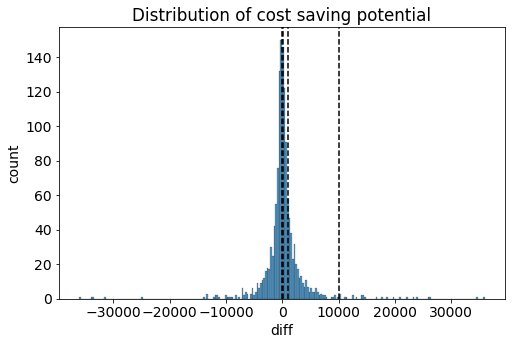

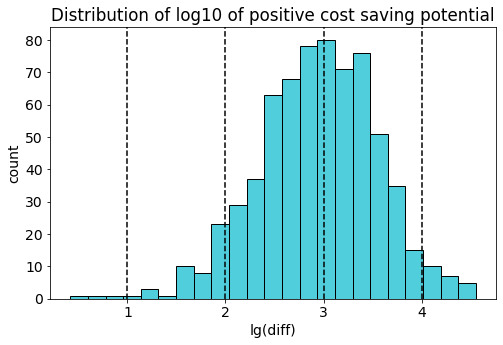

POSITIVES mean: 2.944, std: 0.609


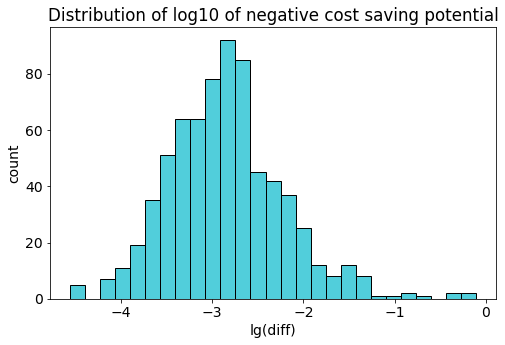

POSITIVES mean: -2.852, std: 0.634


In [43]:
regular_df = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"]))]
regular_diff = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

print(f"Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns {rs_df.shape[0]-regular_diff.shape[0]} instances.")
print(f"Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns {neg_diff.shape[0]} instances.")


plt.figure(figsize=(8,5))
sns.histplot(data=regular_diff)
plt.ylabel("count")
plt.axvline(10, color="black", linestyle="--")
plt.axvline(100, color="black", linestyle="--")
plt.axvline(1000, color="black", linestyle="--")
plt.axvline(10000, color="black", linestyle="--")
plt.title("Distribution of cost saving potential")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=log_pos_diff, color="tab:cyan")
plt.ylabel("count")
plt.axvline(1, color="black", linestyle="--")
plt.axvline(2, color="black", linestyle="--")
plt.axvline(3, color="black", linestyle="--")
plt.axvline(4, color="black", linestyle="--")
plt.xlabel("lg(diff)")
plt.title("Distribution of log10 of positive cost saving potential")
plt.show()
print(f"POSITIVES mean: {log_pos_diff.mean():0.3f}, std: {log_pos_diff.std():0.3f}")


plt.figure(figsize=(8,5))
sns.histplot(data=log_neg_diff, color="tab:cyan")
plt.ylabel("count")
plt.xlabel("lg(diff)")
plt.title("Distribution of log10 of negative cost saving potential")
plt.show()
print(f"POSITIVES mean: {log_neg_diff.mean():0.3f}, std: {log_neg_diff.std():0.3f}")


### Distribution of dependent variable: cost saving potential on Generalization Data

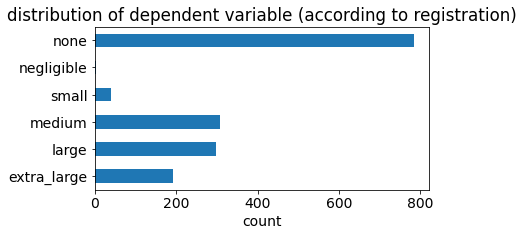

Original potential classes:
 none           783
negligible       3
small           41
medium         307
large          298
extra_large    192
Name: potential, dtype: int64 




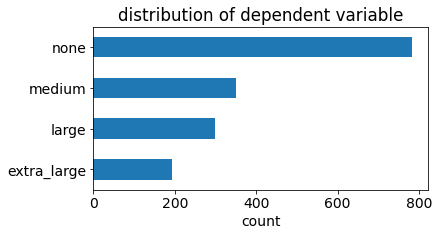

Condensed potential classes:
 none           783
medium         351
large          298
extra_large    192
Name: potential, dtype: int64 




In [44]:
original_classes = ['none','negligible','small','medium','large','extra_large']
plt.figure(figsize=(6,3))
rs_df['potential'].value_counts()[original_classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.title("distribution of dependent variable (according to registration)")
plt.show()
print(f"Original potential classes:\n",rs_df['potential'].value_counts()[original_classes], "\n\n")

# include 'negligible' and 'small' into 'medium'
rs_df.loc[rs_df['potential'] == 'negligible', 'potential'] = "medium"
rs_df.loc[rs_df['potential'] == 'small', 'potential'] = "medium"

classes = ['none','medium','large','extra_large']
plt.figure(figsize=(6,3))
rs_df['potential'].value_counts()[classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("count")
plt.title("distribution of dependent variable")
plt.show()
print(f"Condensed potential classes:\n",rs_df['potential'].value_counts()[classes], "\n\n")

                none medium large extra_large
1_AsIs           101     66    50           6
2_Kawata15        83     59    74           7
3_Peters15        85     58    61          17
4_Canfora13      147     30    20         122
5_Watanabe08     217     59    32          11
6_CamargoCruz09  150     79    61          29


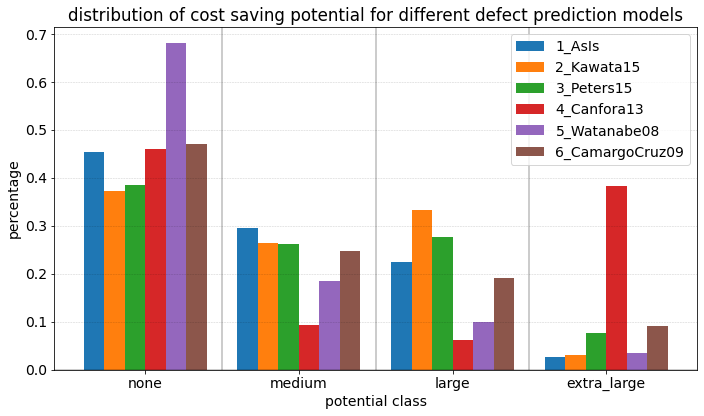

                     none    medium     large extra_large
1_AsIs           0.452915  0.295964  0.224215    0.026906
2_Kawata15       0.372197  0.264574  0.331839     0.03139
3_Peters15       0.384615  0.262443  0.276018    0.076923
4_Canfora13      0.460815  0.094044  0.062696    0.382445
5_Watanabe08     0.680251  0.184953  0.100313    0.034483
6_CamargoCruz09  0.470219  0.247649  0.191223    0.090909


In [45]:
csp_general_df = pd.DataFrame(columns=classes)
for config in general_approach_list:
    csp_general_df = csp_general_df.append(rs_df.loc[rs_df.configuration == config].potential.value_counts()[classes].rename(config))
print(csp_general_df)
csp_general_df = csp_general_df.div(csp_general_df.sum(axis=1), axis=0)

bar_plot_wrapper(csp_general_df.to_numpy().T, x_labels=classes, data_std=None,set_labels=general_approach_list, xlabel="potential class",
                 ylabel="percentage", figsize=(10,6), 
                 rotate_ticks=False, title=f"distribution of cost saving potential for different defect prediction models")
print(csp_general_df)

### Distribution of independent and confounding variables of Generalization Data

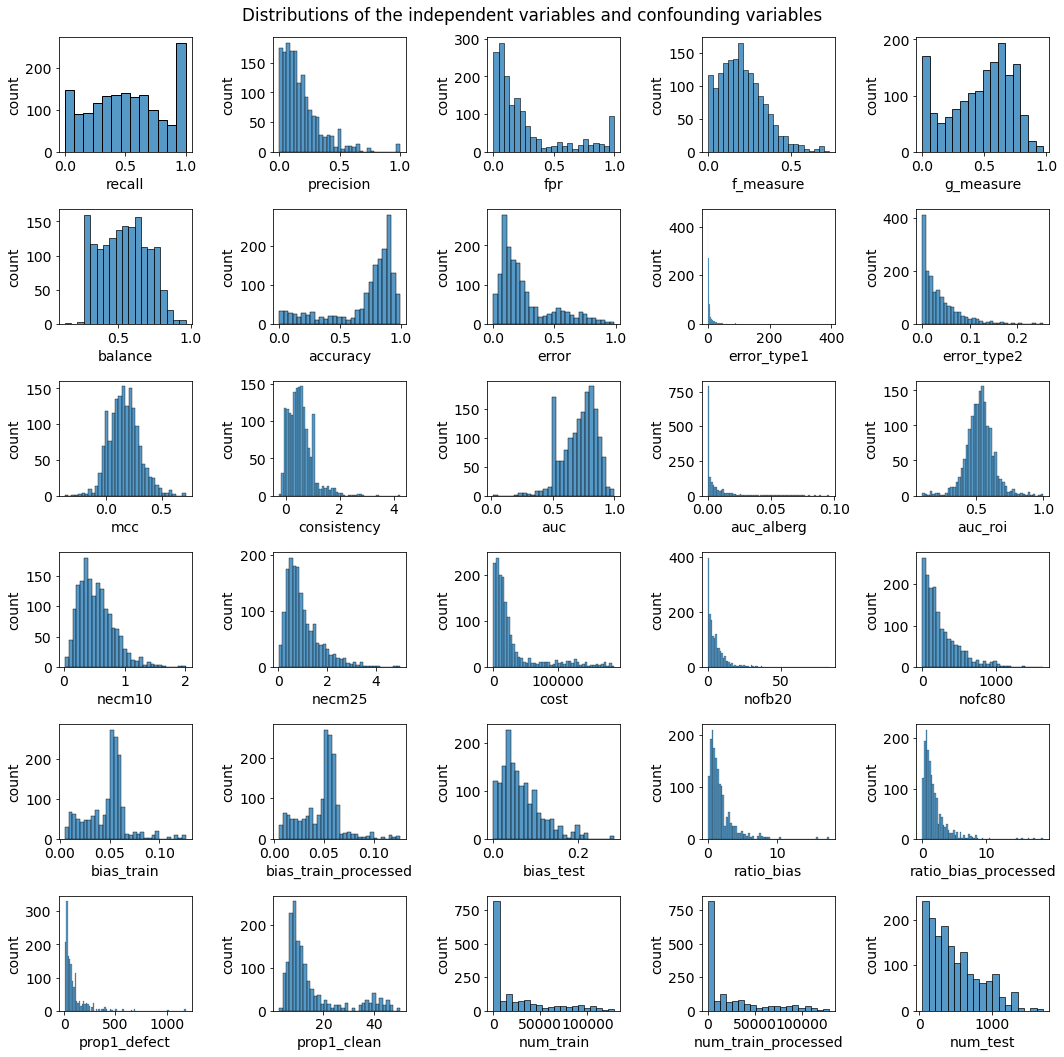

In [46]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))

feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(rs_df, x=rs_df.columns[feature_index], ax=col)
        col.set_ylabel("count")
        feature_index += 1
        
fig.suptitle("Distributions of the independent variables and confounding variables")
plt.tight_layout()
plt.show()


NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.


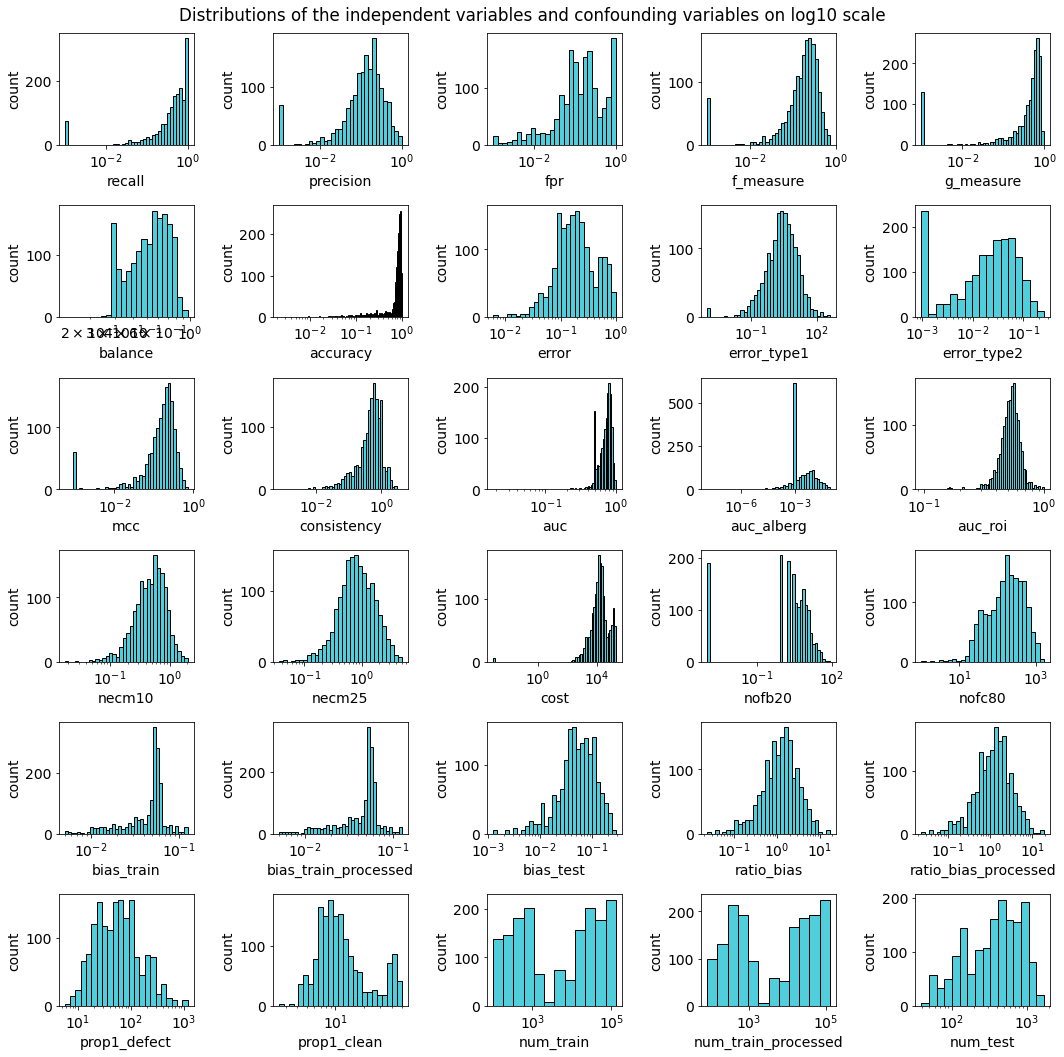

In [47]:
rs_df_4_log = rs_df.copy(deep=True)
rs_df_4_log.replace(to_replace=0, value=0.001, inplace=True)
print("NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.")

fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        if rs_df_4_log[rs_df.columns[feature_index]].min() == 0:
            print(rs_df_4_log.columns[feature_index], rs_df_4_log[rs_df.columns[feature_index]].min())
        sns.histplot(rs_df_4_log, x=rs_df_4_log.columns[feature_index], color="tab:cyan", ax=col, log_scale=True)
        col.set_xlabel(rs_df.columns[feature_index])
        col.set_ylabel("count")
        feature_index += 1

fig.suptitle("Distributions of the independent variables and confounding variables on log10 scale")
plt.tight_layout()
plt.show()

### Boxplots

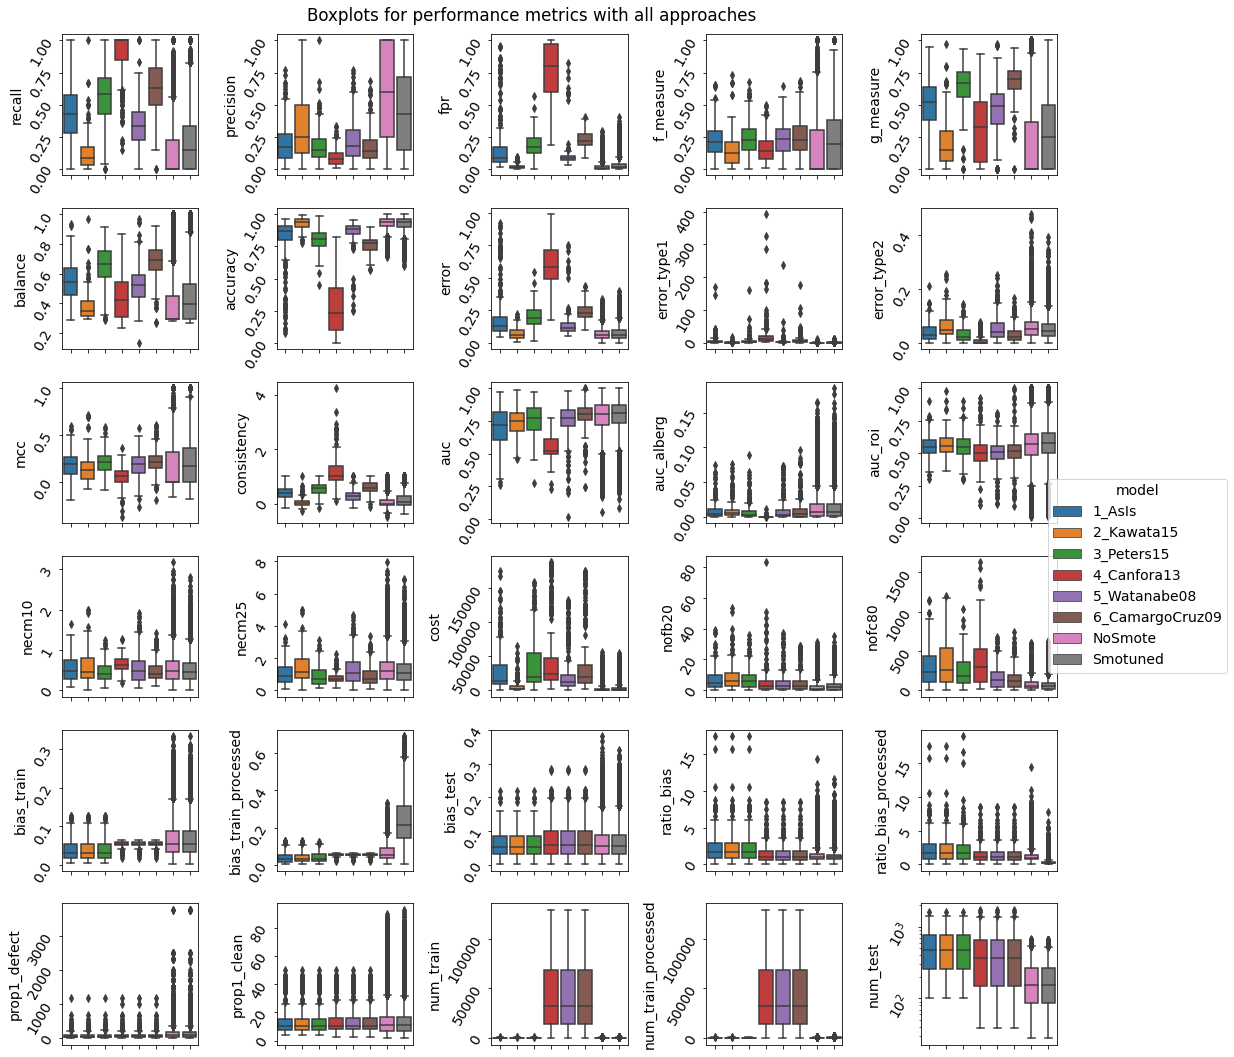

In [48]:
full_df = rs_df.append(bt_df)
full_approach_list = general_approach_list + ['NoSmote','Smotuned']
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
first_flag = True
for row in axes:
    for col in row:
        if first_flag:
            sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,feature_index], hue=full_df.iloc[:,0], ax=col,
               order=full_approach_list, hue_order=full_approach_list)
            col.get_legend().remove()
            handles, labels = col.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15,0.55), title="model")
            plt.gca().set_yscale('log')
            col.clear()
            first_flag = False
        sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,feature_index], ax=col, order=full_approach_list)
        col.set(xticklabels=[])  # remove the tick labels
        col.set(xlabel=None)
        col.tick_params(labelrotation=60)
        feature_index += 1
     
fig.suptitle("Boxplots for performance metrics with all approaches")
plt.tight_layout()
plt.show()

#### Log Boxplots

NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.


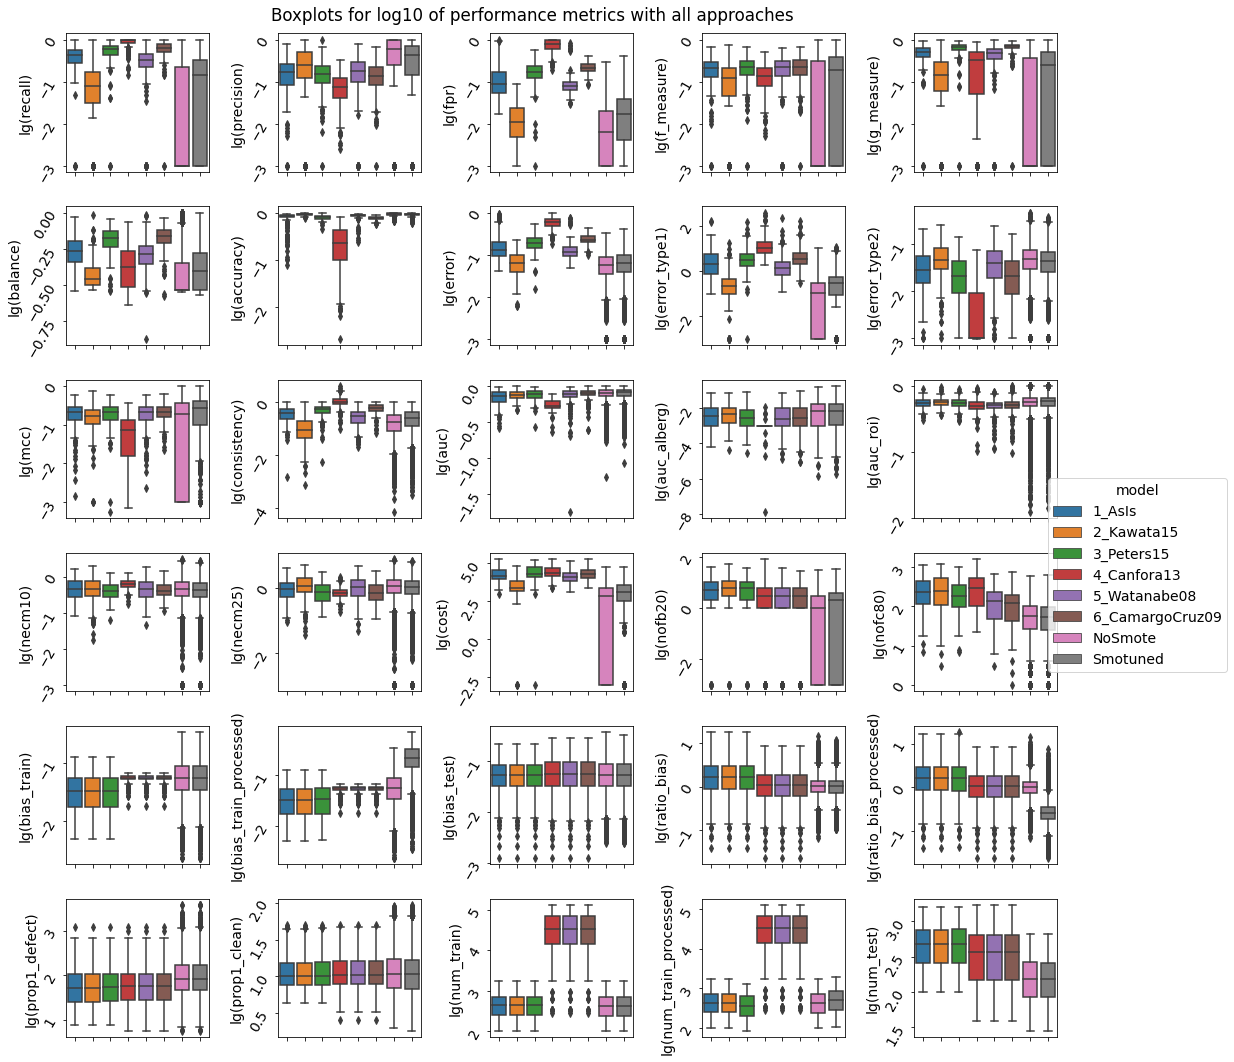

In [49]:
full_df_4_log = full_df.copy(deep=True)
full_df_4_log.replace(to_replace=0, value=0.001, inplace=True)
print("NOTE: For computational reasons all 0 values in this plot are replaced by 1e-3.")

fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
first_flag = True
for row in axes:
    for col in row:
        if first_flag:
            sns.boxplot(x=full_df_4_log.iloc[:,0], y=full_df_4_log.iloc[:,feature_index], hue=full_df_4_log.iloc[:,0], ax=col,
                        order=full_approach_list, hue_order=full_approach_list)
            col.get_legend().remove()
            handles, labels = col.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15,0.55), title="model")
            col.clear()
            first_flag = False
        sns.boxplot(x=full_df_4_log.iloc[:,0], y=np.log10(full_df_4_log.iloc[:,feature_index]), ax=col, order=full_approach_list)
        col.set(xticklabels=[])  # remove the tick labels
        col.set(xlabel=None)
        col.set_ylabel(f"lg({full_df_4_log.columns[feature_index]})")
        col.tick_params(labelrotation=60)
        feature_index += 1

fig.suptitle("Boxplots for log10 of performance metrics with all approaches")
plt.tight_layout()
plt.show()

### Correlation Analysis on Generalization Data

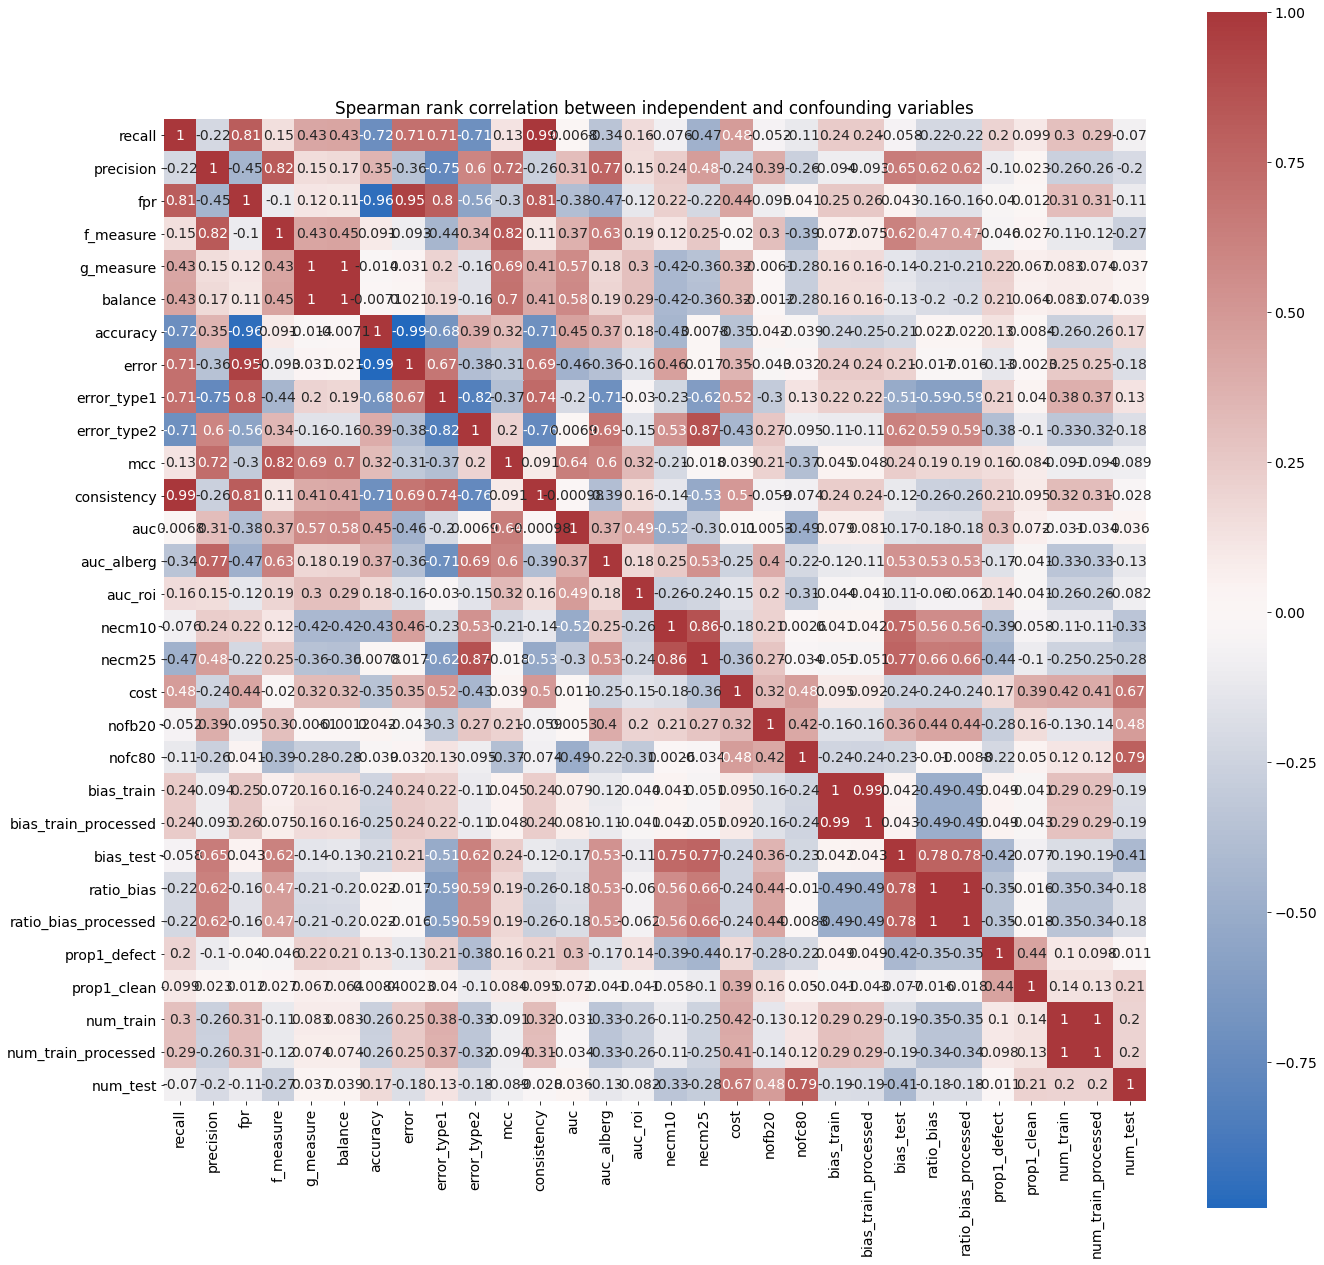

In [50]:
rs_df_numeric = rs_df.iloc[:,FIRST_NUM_FEATURE_IDX:FIRST_NUM_FEATURE_IDX+30]
overall_spearman_corr_map_real = spearmanr(a=rs_df_numeric).correlation

plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map_real, square=True, annot=True, xticklabels=rs_df_numeric.columns, yticklabels=rs_df_numeric.columns, cmap="vlag")
plt.title("Spearman rank correlation between independent and confounding variables")
plt.show()

### Variables cs lg(diff) on Generalization Data

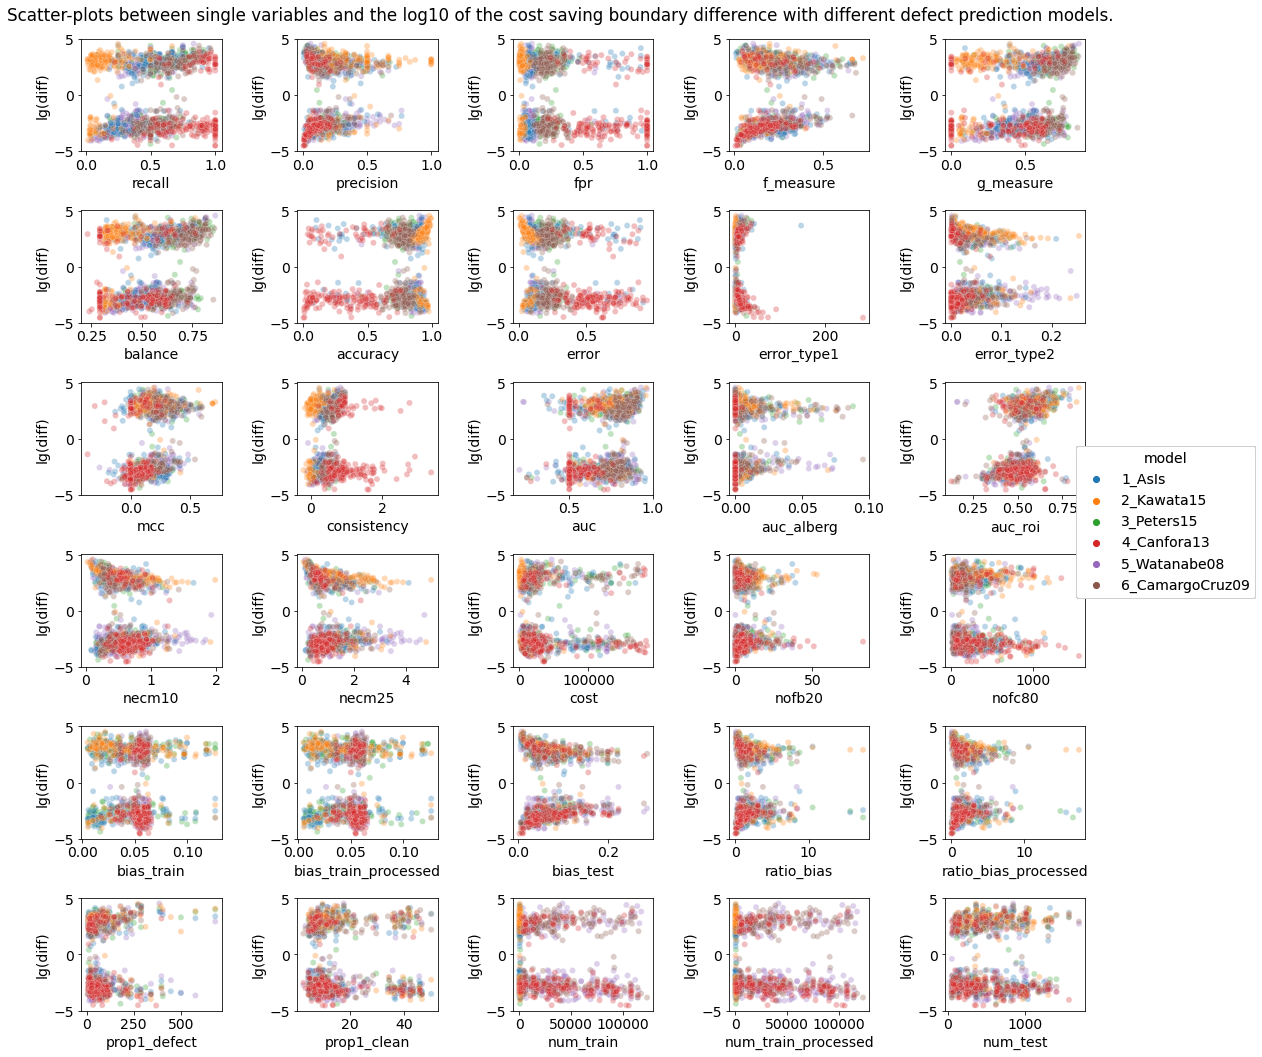

In [51]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        col = sns.scatterplot(x=rs_df.iloc[:,feature_index], y=log_diff, ax=col, alpha=0.3, hue=rs_df.iloc[:,0],
                              hue_order=general_approach_list)
        col.set_ylabel("lg(diff)")
        col.get_legend().remove()
        handles, labels = col.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15,0.58), title="model")
        feature_index += 1

fig.suptitle("Scatter-plots between single variables and the log10 of the cost saving boundary difference with different defect prediction models.")
plt.tight_layout()
plt.show()

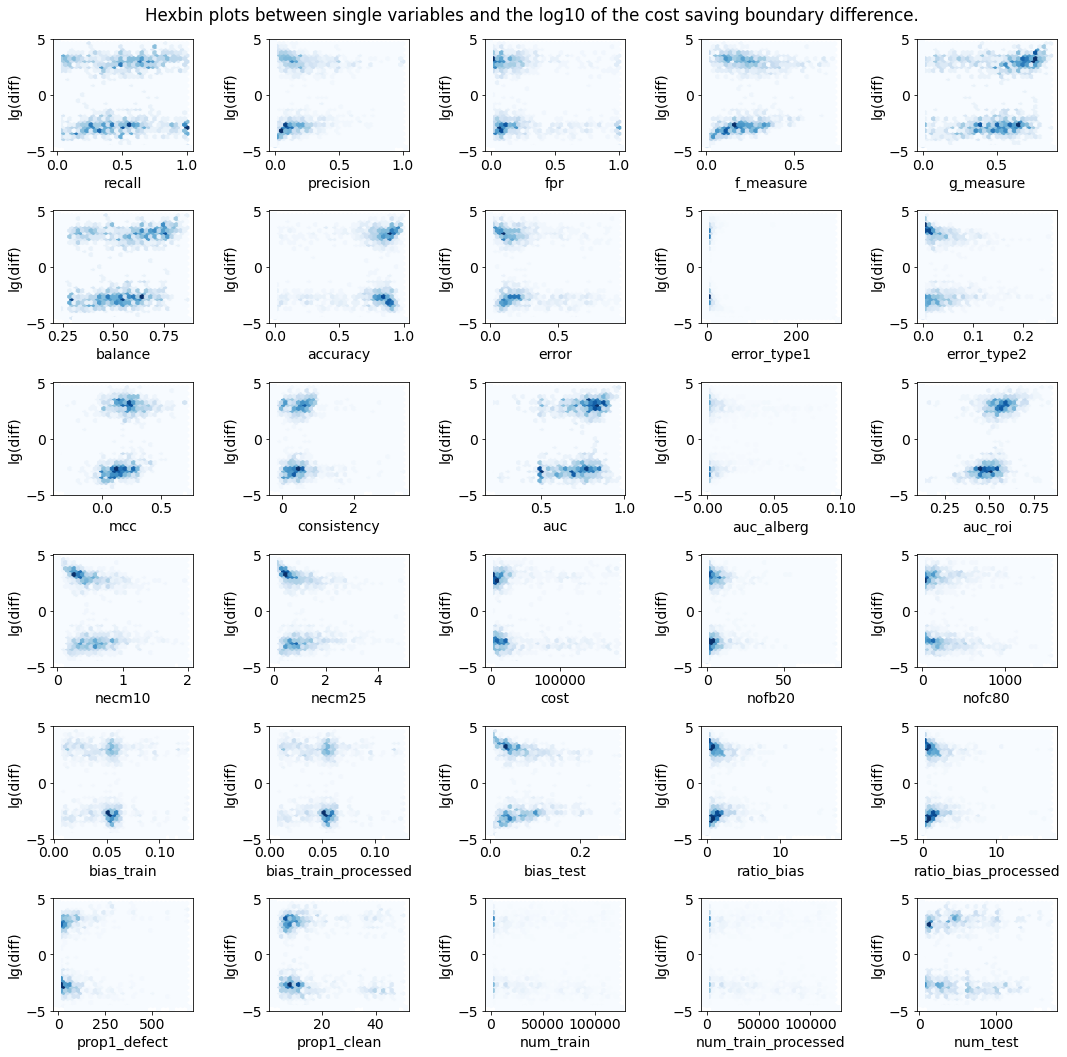

In [52]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        hb = col.hexbin(x=regular_df.iloc[:,feature_index], y=log_diff, gridsize=30, cmap='Blues', marginals=True)
        col.set_ylabel("lg(diff)")
        col.set_xlabel(regular_df.columns[feature_index])
        feature_index += 1

fig.suptitle("Hexbin plots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()

### Sensitivity Analysis on Generalization Data

In [53]:
region_medium_large = rs_df.loc[(rs_df["diff"]>900) & (rs_df["diff"]<1100)].shape[0]
print(f"Elements in boundary region medium-large [900,1100]: {region_medium_large}")
print(f"{100* region_medium_large / rs_df['potential'].value_counts()['medium']:0.1f}% of medium "
      f"and {100* region_medium_large / rs_df['potential'].value_counts()['large']:0.1f}% of large")
print()
region_large_extralarge = rs_df.loc[(rs_df["diff"]>9000) & (rs_df["diff"]<11000)].shape[0]
print(f"Instances in boundary region large-extra_large [9000,11000]: {region_large_extralarge}")
print(f"{100* region_large_extralarge / rs_df['potential'].value_counts()['large']:0.1f}% of large "
      f"and {100* region_large_extralarge / rs_df['potential'].value_counts()['extra_large']:0.1f}% of extra_large")

Elements in boundary region medium-large [900,1100]: 34
9.7% of medium and 11.4% of large

Instances in boundary region large-extra_large [9000,11000]: 7
2.3% of large and 3.6% of extra_large


## Test Models on Generalization Data

In [54]:
rs_df_features = rs_df.drop(['release', 'configuration', 'diff','potential'], axis = 1)

y_real = rs_df['potential']
X_real_unnormed = rs_df_features

name             GeneralLogisticRegression
training t.                              0
prediction t.                            0
recall                             0.27405
precision                         0.310075
accuracy                          0.241995
F1 measure                        0.188166
MCC                               0.059982
dtype: object


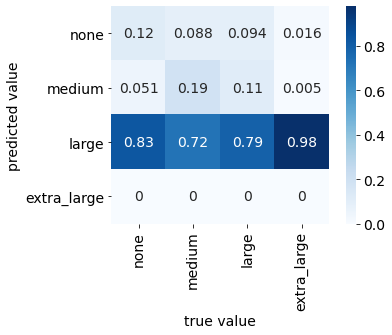

                              none    medium     large  extra_large
correctly_predicted       0.116220  0.188034  0.791946     0.000000
moderate_overprediction   0.051086  0.723647  0.000000          NaN
overall_overprediction    0.883780  0.723647  0.000000          NaN
moderate_underprediction       NaN  0.088319  0.114094     0.979167
overall_underprediction        NaN  0.088319  0.208054     1.000000


In [55]:
y_real_model = model_lr.predict(X_real_unnormed[['g_measure', 'bias_test', 'num_train']])
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralLogisticRegression", df=metrics_df), ignore_index=True)

name             GeneralDecisionTree
training t.                        0
prediction t.                      0
recall                      0.352253
precision                   0.611004
accuracy                    0.285714
F1 measure                  0.260832
MCC                         0.187383
dtype: object


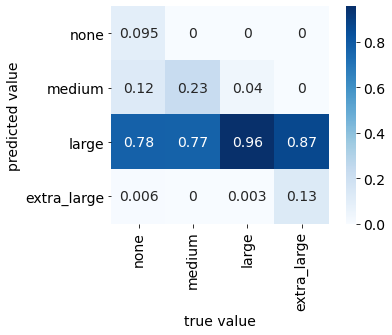

                              none   medium     large  extra_large
correctly_predicted       0.094508  0.22792  0.956376     0.130208
moderate_overprediction   0.123883  0.77208  0.003356          NaN
overall_overprediction    0.905492  0.77208  0.003356          NaN
moderate_underprediction       NaN  0.00000  0.040268     0.869792
overall_underprediction        NaN  0.00000  0.040268     0.869792


In [56]:
y_real_model = model_dt.predict(X_real_unnormed)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralDecisionTree", df=metrics_df), ignore_index=True)

name             GeneralRandomForest
training t.                        0
prediction t.                      0
recall                      0.498777
precision                   0.573445
accuracy                    0.392241
F1 measure                  0.429376
MCC                         0.277889
dtype: object


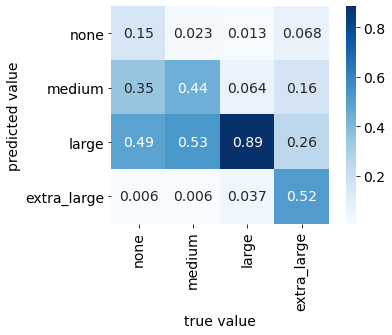

                              none    medium     large  extra_large
correctly_predicted       0.151980  0.441595  0.885906     0.515625
moderate_overprediction   0.353768  0.529915  0.036913          NaN
overall_overprediction    0.848020  0.535613  0.036913          NaN
moderate_underprediction       NaN  0.022792  0.063758     0.255208
overall_underprediction        NaN  0.022792  0.077181     0.484375


In [57]:
y_real_model = model_rf.predict(X_real_unnormed)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralRandomForest", df=metrics_df), ignore_index=True)

### model performance overview

In [58]:
metrics_df

name  training t.  prediction t.    recall  precision  \
0         LogisticRegression     0.821317       0.014296  0.500484   0.630980   
1         LogisticRegression    46.845188       0.002764  0.582272   0.588695   
2               DecisionTree     0.345682       0.006040  0.856248   0.914292   
3          TunedRandomForest    10.984343       0.126209  0.940783   0.966838   
4  GeneralLogisticRegression     0.000000       0.000000  0.274050   0.310075   
5        GeneralDecisionTree     0.000000       0.000000  0.352253   0.611004   
6        GeneralRandomForest     0.000000       0.000000  0.498777   0.573445   

   accuracy  F1 measure       MCC  
0  0.790717    0.476058  0.675043  
1  0.819075    0.583126  0.712153  
2  0.924283    0.879277  0.881885  
3  0.972283    0.953108  0.956578  
4  0.241995    0.188166  0.059982  
5  0.285714    0.260832  0.187383  
6  0.392241    0.429376  0.277889

# Plots for Paper

In [59]:
def update_ticklabels(ax):
    label_replacements = {'intercept': 'Intercept',
                      'Intercept': 'Intercept',
                      'recall': 'recall',
                      'precision': 'precision',
                      'fpr': 'fpr',
                      'f_measure': 'F-measure',
                      'g_measure': 'G-measure',
                      'balance': 'balance',
                      'accuracy': 'accuracy',
                      'error': 'error',
                      'error_type1': 'error$_\mathrm{TypeI}$',
                      'error_type2': 'error$_\mathrm{TypeII}$',
                      'mcc': 'MCC',
                      'consistency': 'consistency',
                      'auc': 'AUC',
                      'auc_alberg': 'AUC$_\mathrm{Alberg}$',
                      'auc_roi': 'AUC$_\mathrm{recall, pf}$',
                      'necm10': 'NECM$_\mathrm{10}$',
                      'necm25': 'NECM$_\mathrm{25}$',
                      'cost': 'cost',
                      'nofb20': 'NofB$_\mathrm{20}\%$',
                      'nofc80': 'NofC$_\mathrm{80}\%$',
                      'bias_train': 'bias$_\mathrm{train}$',
                      'bias_train_processed': "bias'$_\mathrm{train}$",
                      'bias_test': 'bias$_\mathrm{test}$',
                      'ratio_bias': '$\Delta_\mathrm{ratio}$bias',
                      'ratio_bias_processed': "$\Delta_\mathrm{ratio}$bias'",
                      'prop1_defect': 'prop$^\mathrm{1\%}_\mathrm{def}$',
                      'prop1_clean': 'prop$^\mathrm{1\%}_\mathrm{clean}$',
                      'num_train': 'N$_\mathrm{train}$',
                      'num_train_processed': "N'$_\mathrm{train}$",
                      'num_test': 'N$_\mathrm{test}$',
                      'diff': 'diff', 
                      'potential': 'potential',
                      'extra_large': 'extra large'
                    }
    
    x_labels = []
    for item in ax.get_xticklabels():
        if item.get_text() in label_replacements:
            x_labels.append(label_replacements[item.get_text()])
        else:
            x_labels.append(item.get_text())
    
    y_labels = []
    for item in ax.get_yticklabels():
        if item.get_text() in label_replacements:
            y_labels.append(label_replacements[item.get_text()])
        else:
            y_labels.append(item.get_text())

    if ax.get_ylabel() in label_replacements:
        ax.set_ylabel(label_replacements[ax.get_ylabel()])
            
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    
def update_labels(fig):
    for ax in fig.get_axes():
        update_ticklabels(ax)

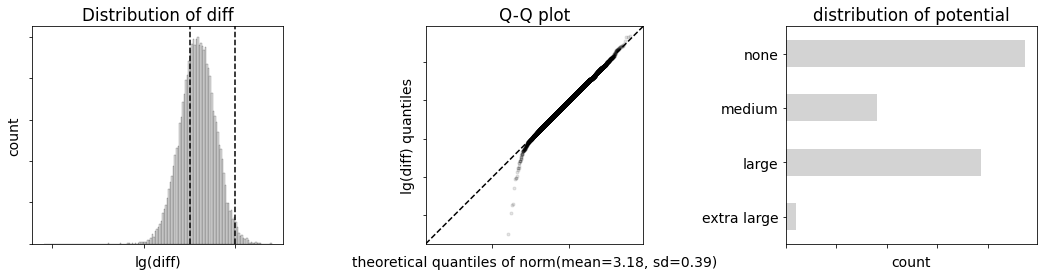

3.1818855150792946 0.3854386245566606 1520.1467490918355


In [60]:
regular_df = bt_df.loc[~(bt_df['diff'].isnull()) & ~(np.isinf(bt_df["diff"]))]
regular_diff = bt_df.loc[~(bt_df['diff'].isnull()) & ~(np.isinf(bt_df["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

ax = axes[0]
sns.histplot(data=log_pos_diff, color="lightgray", ax=ax)
ax.set_ylabel("count")
ax.axvline(3, color="black", linestyle="--")
ax.axvline(4, color="black", linestyle="--")
ax.set_xlabel("lg(diff)")
ax.set_title("Distribution of diff")

ax = axes[1]
pp = sm.ProbPlot(log_pos_diff, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.1, ax=ax)
sm.qqline(ax, line='45', fmt='k--')

ax.set_title(label="")
ax.set_ylabel('lg(diff) quantiles')
ax.set_xlabel('theoretical quantiles of norm(mean=3.18, sd=0.39)')
ax.set_title("Q-Q plot")
ax.set_aspect('equal', 'box')

ax = axes[2]
classes = ['none','medium','large','extra_large']
bt_df['potential'].value_counts()[classes].plot(kind='barh', color='lightgrey', ax=ax)
ax.invert_yaxis()
ax.set_xlabel("count")

ax.set_title("distribution of potential")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

update_labels(fig)

plt.savefig(os.path.join(PLOTS_DIR, "dist_pos_qq.png"), bbox_inches='tight')
plt.show()

mean, sd = norm.fit(log_pos_diff)
print(mean, sd, 10**mean)

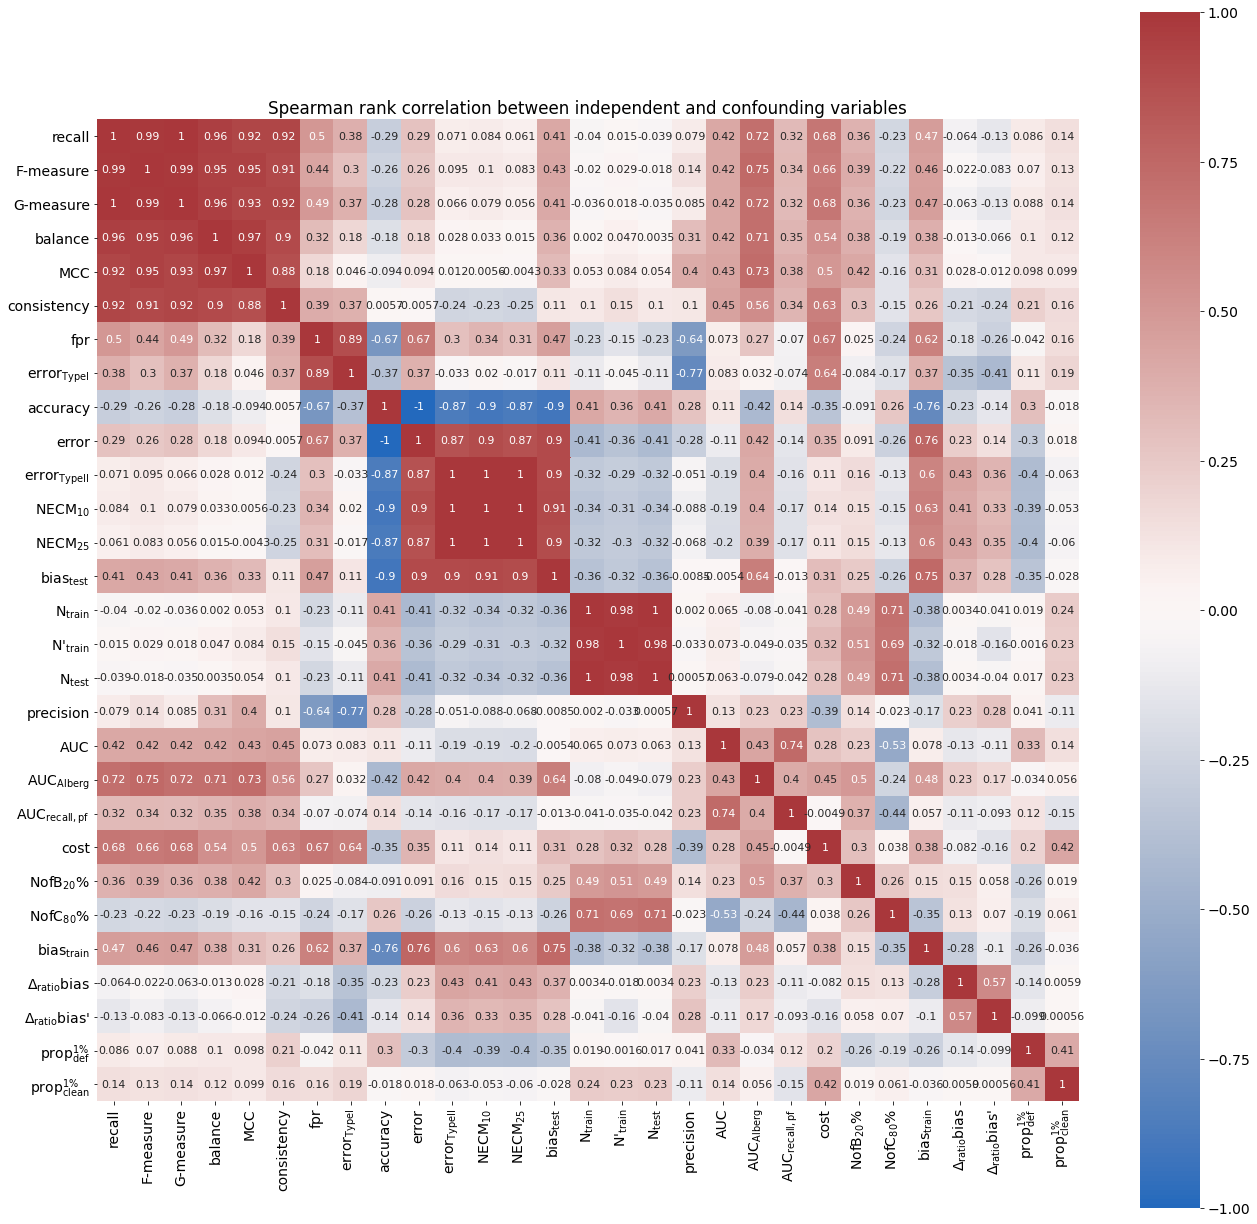

In [61]:
df_numeric_reordered = df_numeric[['recall', 'f_measure', 'g_measure', 'balance', 'mcc', 'consistency', 'fpr', 'error_type1', 'accuracy', 'error', 'error_type2', 'necm10', 'necm25', 'bias_test', 'num_train', 'num_train_processed', 'num_test',
'precision', 'auc', 'auc_alberg', 'auc_roi', 'cost', 'nofb20', 'nofc80', 'bias_train', 'ratio_bias', 'ratio_bias_processed', 'prop1_defect', 'prop1_clean']]

overall_spearman_corr_map = spearmanr(a=df_numeric_reordered).correlation

fig = plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map, square=True, annot=True, xticklabels=df_numeric_reordered.columns,
                 yticklabels=df_numeric_reordered.columns, cmap="vlag", annot_kws={"size": heatmap_fontsize})

plt.title("Spearman rank correlation between independent and confounding variables")

update_labels(fig)

plt.savefig(os.path.join(PLOTS_DIR, "corr_all.pdf"), bbox_inches='tight')
plt.show()

potential  intercept  g_measure  bias_test  num_train
0  extra_large  -1.596840   1.355202  -0.329081  -0.000604
1        large  -1.093505   3.395283  -0.399102   0.002430
2       medium   0.507447   2.021842   1.364484  -0.002067
3         none   2.182898  -6.772328  -0.636301   0.000240

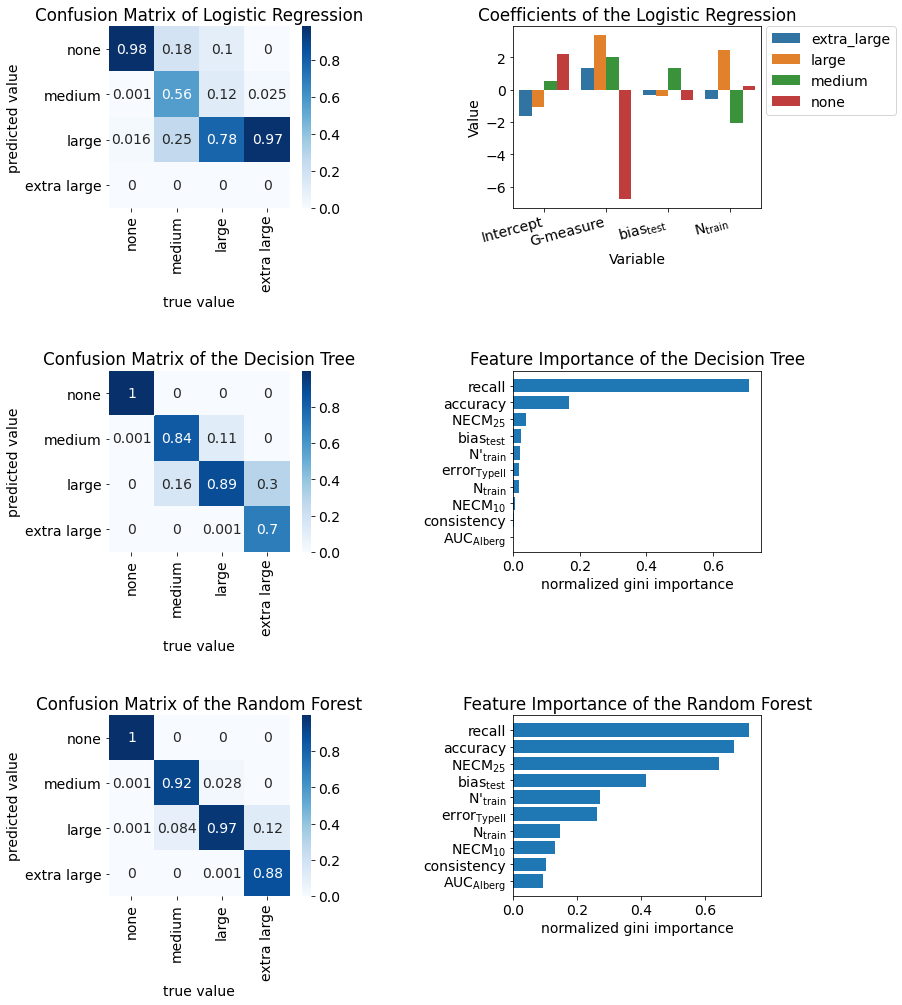

In [62]:
intercept_and_coef = np.insert(model_lr.coef_.T, 0, model_lr.intercept_, axis=0).T
coef_labels = ['g_measure', 'bias_test', 'num_train']
coef_labels.insert(0, "intercept")
coeff_df = pd.DataFrame(intercept_and_coef, columns=coef_labels)
coeff_df.insert(0, 'potential', model_lr.classes_)
display(coeff_df.loc[:, (coeff_df != 0).any(axis=0)])

melted_coeffs = coeff_df.loc[:, (coeff_df != 0).any(axis=0)].melt(id_vars=['potential'])
melted_coeffs.loc[melted_coeffs['variable']=='num_train', 'value'] *= 1000

fig, axes = plt.subplots(3,2, figsize=(12,16))
ax = axes[0,0]
y_pred_lr = model_lr.predict(X_unnormed[['g_measure', 'bias_test', 'num_train']])
cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred_lr, labels=classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.transpose()
cm_norm = np.round(cm_norm, 3)
sns.heatmap(cm_norm, square=True, annot=True, cmap="Blues", ax=ax)
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes, rotation=0)
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
ax.set_title('Confusion Matrix of Logistic Regression')

ax = axes[0,1]
sns.barplot(data=melted_coeffs, x="variable", y='value', hue="potential", ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Variable')
ax.set_ylabel('Value')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
ax.set_title('Coefficients of the Logistic Regression')

ax = axes[1,0]
y_pred_dt = model_dt.predict(X_unnormed)
cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred_dt, labels=classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.transpose()
cm_norm = np.round(cm_norm, 3)
sns.heatmap(cm_norm, square=True, annot=True, cmap="Blues", ax=ax)
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes, rotation=0)
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
ax.set_title('Confusion Matrix of the Decision Tree')


ax = axes[1,1]
ax.barh(dt_feat_importance_df[:10]["feature"], dt_feat_importance_df[:10]["importance"])
ax.set_xlabel("normalized gini importance")
ax.invert_yaxis()
ax.set_title("Feature Importance of the Decision Tree")

ax = axes[2,0]
y_pred_rf = model_rf.predict(X_unnormed)
cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred_rf, labels=classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.transpose()
cm_norm = np.round(cm_norm, 3)
sns.heatmap(cm_norm, square=True, annot=True, cmap="Blues", ax=ax)
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes, rotation=0)
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
ax.set_title('Confusion Matrix of the Random Forest')


ax = axes[2,1]
ax.barh(rf_feat_importance_df[:10]["feature"], rf_feat_importance_df[:10]["mean"])
ax.set_xlabel("normalized gini importance")
ax.invert_yaxis()
ax.set_title("Feature Importance of the Random Forest")
ax.set_yticklabels(dt_feat_importance_df[:10]["feature"])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.9)

update_labels(fig)

plt.savefig(os.path.join(PLOTS_DIR, "bootstrap_results.pdf"), bbox_inches="tight")
plt.show()

In [63]:
print('num +inf:', sum(np.isinf(rs_df['diff']) & (rs_df['diff']>0)))
print('num -inf:', sum(np.isinf(rs_df['diff']) & (rs_df['diff']<0)))
print('num NaN:', sum(rs_df['diff'].isna()))

num +inf: 167
num -inf: 69
num NaN: 5


positive normal: 2.9435116407840622 0.6088497343272417 878.0346215296715
negative normal: -2.8518817176302784 0.6331333312060976 0.0014064305206676713


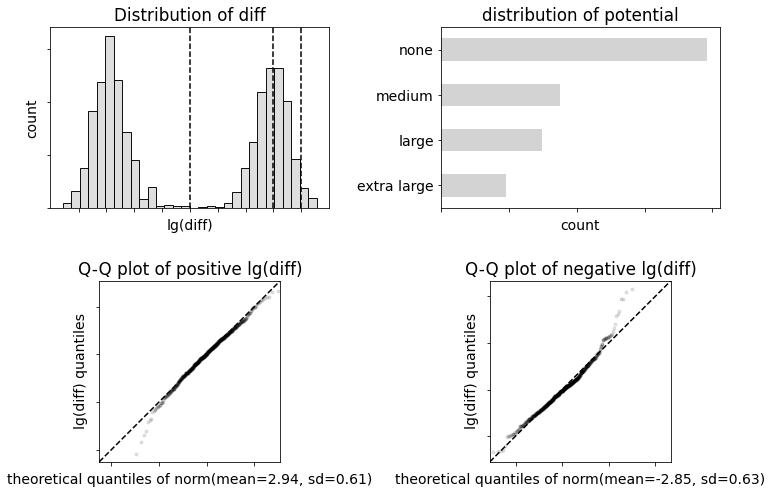

In [64]:
regular_df = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"]))]
regular_diff = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

mean_pos, sd_pos = norm.fit(log_pos_diff)
print("positive normal:", mean_pos, sd_pos, 10**mean_pos)
mean_neg, sd_neg = norm.fit(log_neg_diff[~np.isnan(log_neg_diff)])
print("negative normal:", mean_neg, sd_neg, 10**mean_neg)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = axes[0, 0]
sns.histplot(data=np.append(log_pos_diff, log_neg_diff), bins=30, color="lightgray", ax=ax)
ax.set_ylabel("count")
ax.axvline(0, color="black", linestyle="--")
ax.axvline(3, color="black", linestyle="--")
ax.axvline(4, color="black", linestyle="--")
ax.set_xticks(range(-4, 5))
ax.set_xlabel("lg(diff)")
ax.set_title("Distribution of diff")

ax = axes[1,0]
pp = sm.ProbPlot(log_pos_diff, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.1, ax=ax)
sm.qqline(ax, line='45', fmt='k--')

ax.set_title(label="")
ax.set_ylabel('lg(diff) quantiles')
ax.set_xlabel('theoretical quantiles of norm(mean=%.2f, sd=%.2f)' %(mean_pos, sd_pos))
ax.set_title("Q-Q plot of positive lg(diff)")
ax.set_aspect('equal', 'box')


ax = axes[1,1]
pp = sm.ProbPlot(log_neg_diff[~np.isnan(log_neg_diff)], fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.1, ax=ax)
sm.qqline(ax, line='45', fmt='k--')

ax.set_title(label="")
ax.set_ylabel('lg(diff) quantiles')
ax.set_xlabel('theoretical quantiles of norm(mean=%.2f, sd=%.2f)' %(mean_neg, sd_neg))
ax.set_title("Q-Q plot of negative lg(diff)")
ax.set_aspect('equal', 'box')

ax = axes[0,1]
classes = ['none','medium','large','extra_large']
rs_df['potential'].value_counts()[classes].plot(kind='barh', color='lightgrey', ax=ax)
ax.invert_yaxis()
ax.set_xlabel("count")

ax.set_title("distribution of potential")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

update_labels(fig)

plt.savefig(os.path.join(PLOTS_DIR, "dist_plots_gen.png"), bbox_inches='tight')
plt.show()

only cross-version
positive normal: 3.0003872431200627 0.5919882556667528 1000.8920578827887
negative normal: -2.83537118287133 0.6369616357685428 0.0014609280145474657


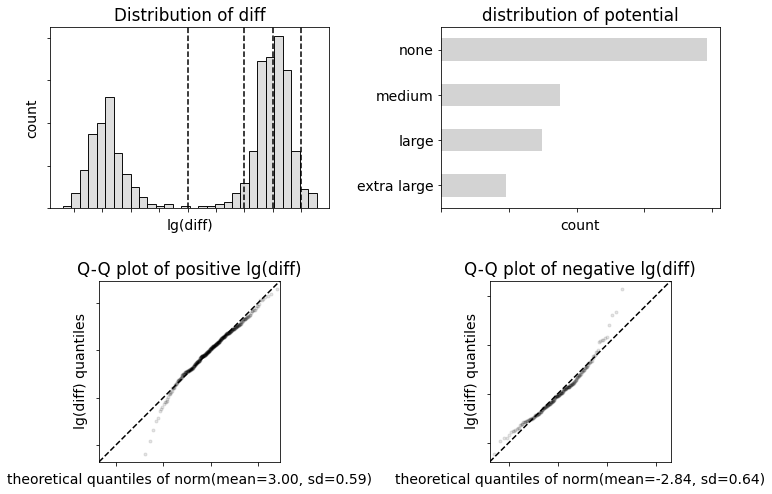

In [65]:
print('only cross-version')
regular_diff = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"])) & rs_df['configuration'].str.match('(1|2|3)_.*') , 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

mean_pos, sd_pos = norm.fit(log_pos_diff)
print("positive normal:", mean_pos, sd_pos, 10**mean_pos)
mean_neg, sd_neg = norm.fit(log_neg_diff[~np.isnan(log_neg_diff)])
print("negative normal:", mean_neg, sd_neg, 10**mean_neg)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = axes[0, 0]
sns.histplot(data=np.append(log_pos_diff, log_neg_diff), bins=30, color="lightgray", ax=ax)
ax.set_ylabel("count")
ax.axvline(0, color="black", linestyle="--")
ax.axvline(2, color="black", linestyle="--")
ax.axvline(3, color="black", linestyle="--")
ax.axvline(4, color="black", linestyle="--")

ax.set_xticks(range(-4, 5))
ax.set_xlabel("lg(diff)")
ax.set_title("Distribution of diff")

ax = axes[1,0]
pp = sm.ProbPlot(log_pos_diff, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.1, ax=ax)
sm.qqline(ax, line='45', fmt='k--')

ax.set_title(label="")
ax.set_ylabel('lg(diff) quantiles')
ax.set_xlabel('theoretical quantiles of norm(mean=%.2f, sd=%.2f)' %(mean_pos, sd_pos))
ax.set_title("Q-Q plot of positive lg(diff)")
ax.set_aspect('equal', 'box')


ax = axes[1,1]
pp = sm.ProbPlot(log_neg_diff[~np.isnan(log_neg_diff)], fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.1, ax=ax)
sm.qqline(ax, line='45', fmt='k--')

ax.set_title(label="")
ax.set_ylabel('lg(diff) quantiles')
ax.set_xlabel('theoretical quantiles of norm(mean=%.2f, sd=%.2f)' %(mean_neg, sd_neg))
ax.set_title("Q-Q plot of negative lg(diff)")
ax.set_aspect('equal', 'box')

ax = axes[0,1]
classes = ['none','medium','large','extra_large']
rs_df['potential'].value_counts()[classes].plot(kind='barh', color='lightgrey', ax=ax)
ax.invert_yaxis()
ax.set_xlabel("count")

ax.set_title("distribution of potential")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

update_labels(fig)

plt.show()

only cross-project
positive normal: 2.869105887043131 0.6224296002401749 739.7856231096104
negative normal: -2.8591155421899797 0.6313126877230919 0.0013831983360127257


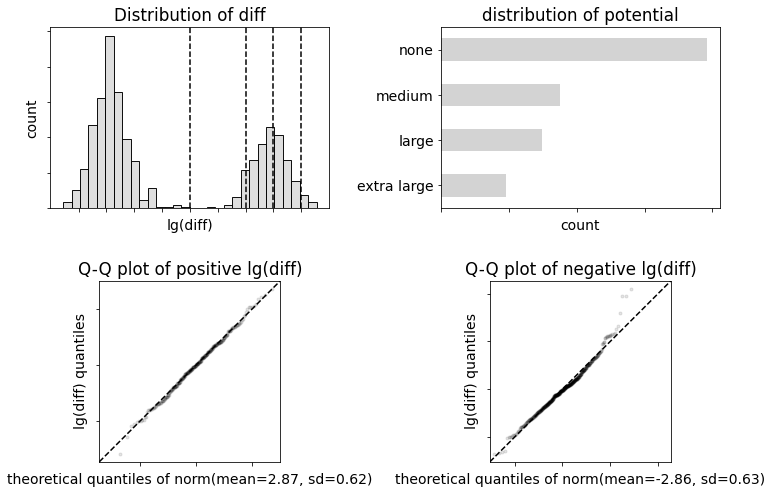

In [66]:
print('only cross-project')
regular_diff = rs_df.loc[~(rs_df['diff'].isnull()) & ~(np.isinf(rs_df["diff"])) & rs_df['configuration'].str.match('(4|5|6)_.*') , 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

mean_pos, sd_pos = norm.fit(log_pos_diff)
print("positive normal:", mean_pos, sd_pos, 10**mean_pos)
mean_neg, sd_neg = norm.fit(log_neg_diff[~np.isnan(log_neg_diff)])
print("negative normal:", mean_neg, sd_neg, 10**mean_neg)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = axes[0, 0]
sns.histplot(data=np.append(log_pos_diff, log_neg_diff), bins=30, color="lightgray", ax=ax)
ax.set_ylabel("count")
ax.axvline(0, color="black", linestyle="--")
ax.axvline(2, color="black", linestyle="--")
ax.axvline(3, color="black", linestyle="--")
ax.axvline(4, color="black", linestyle="--")

ax.set_xticks(range(-4, 5))
ax.set_xlabel("lg(diff)")
ax.set_title("Distribution of diff")

ax = axes[1,0]
pp = sm.ProbPlot(log_pos_diff, fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.1, ax=ax)
sm.qqline(ax, line='45', fmt='k--')

ax.set_title(label="")
ax.set_ylabel('lg(diff) quantiles')
ax.set_xlabel('theoretical quantiles of norm(mean=%.2f, sd=%.2f)' %(mean_pos, sd_pos))
ax.set_title("Q-Q plot of positive lg(diff)")
ax.set_aspect('equal', 'box')


ax = axes[1,1]
pp = sm.ProbPlot(log_neg_diff[~np.isnan(log_neg_diff)], fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='k', markeredgecolor='k', alpha=0.1, ax=ax)
sm.qqline(ax, line='45', fmt='k--')

ax.set_title(label="")
ax.set_ylabel('lg(diff) quantiles')
ax.set_xlabel('theoretical quantiles of norm(mean=%.2f, sd=%.2f)' %(mean_neg, sd_neg))
ax.set_title("Q-Q plot of negative lg(diff)")
ax.set_aspect('equal', 'box')

ax = axes[0,1]
classes = ['none','medium','large','extra_large']
rs_df['potential'].value_counts()[classes].plot(kind='barh', color='lightgrey', ax=ax)
ax.invert_yaxis()
ax.set_xlabel("count")

ax.set_title("distribution of potential")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

update_labels(fig)

plt.show()

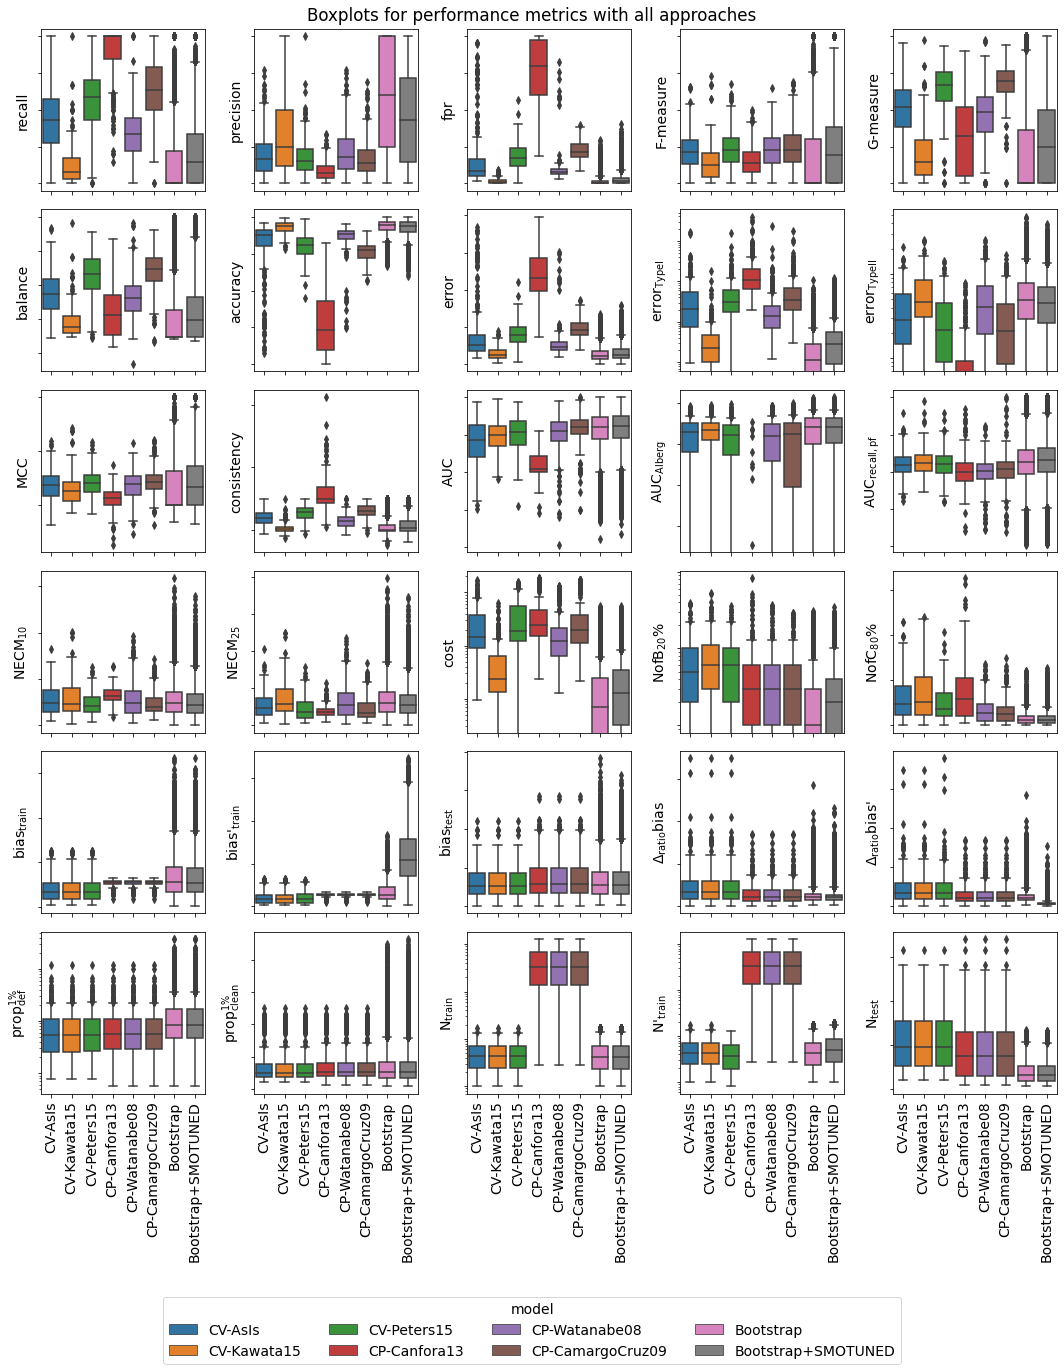

In [67]:
full_df = rs_df.append(bt_df)
full_approach_list = general_approach_list + ['NoSmote','Smotuned']
fig, axes = plt.subplots(6, 5, figsize=(15,18))
feature_index = FIRST_NUM_FEATURE_IDX
first_flag = True
for row in axes:
    for col in row:
        if first_flag:
            sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,feature_index], hue=full_df.iloc[:,0], ax=col,
               order=full_approach_list, hue_order=full_approach_list)
            col.get_legend().remove()
            handles, labels = col.get_legend_handles_labels()
            col.clear()
            first_flag = False
        sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,feature_index], ax=col, order=full_approach_list)
        if col not in axes[-1,:]:
            col.set_xticklabels([])  # remove the tick labels
            col.set_xlabel(None)
        else:
            col.set_xticklabels(['CV-AsIs', 'CV-Kawata15', 'CV-Peters15', 'CP-Canfora13', 'CP-Watanabe08', 'CP-CamargoCruz09', 'Bootstrap', 'Bootstrap+SMOTUNED'])
            col.set_xlabel(None)
        col.tick_params(labelrotation=90)
        if full_df.columns[feature_index] in set(['auc_alberg', 'error_type1', 'error_type2', 'cost', 'nofb20', 'prop1_defect', 'prob1_clean', 'num_train', 'num_train_processed', 'num_train']):
            col.set_yscale('log')
        feature_index += 1

fig.legend(handles, ['CV-AsIs', 'CV-Kawata15', 'CV-Peters15', 'CP-Canfora13', 'CP-Watanabe08', 'CP-CamargoCruz09', 'Bootstrap', 'Bootstrap+SMOTUNED'],loc='upper center', bbox_to_anchor=(0.5, -0.01), title="model", ncol=4) # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15,0.55), title="model")
fig.suptitle("Boxplots for performance metrics with all approaches")

update_labels(fig)

plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "boxplot_all_approaches.pdf"), bbox_inches='tight')
plt.show()

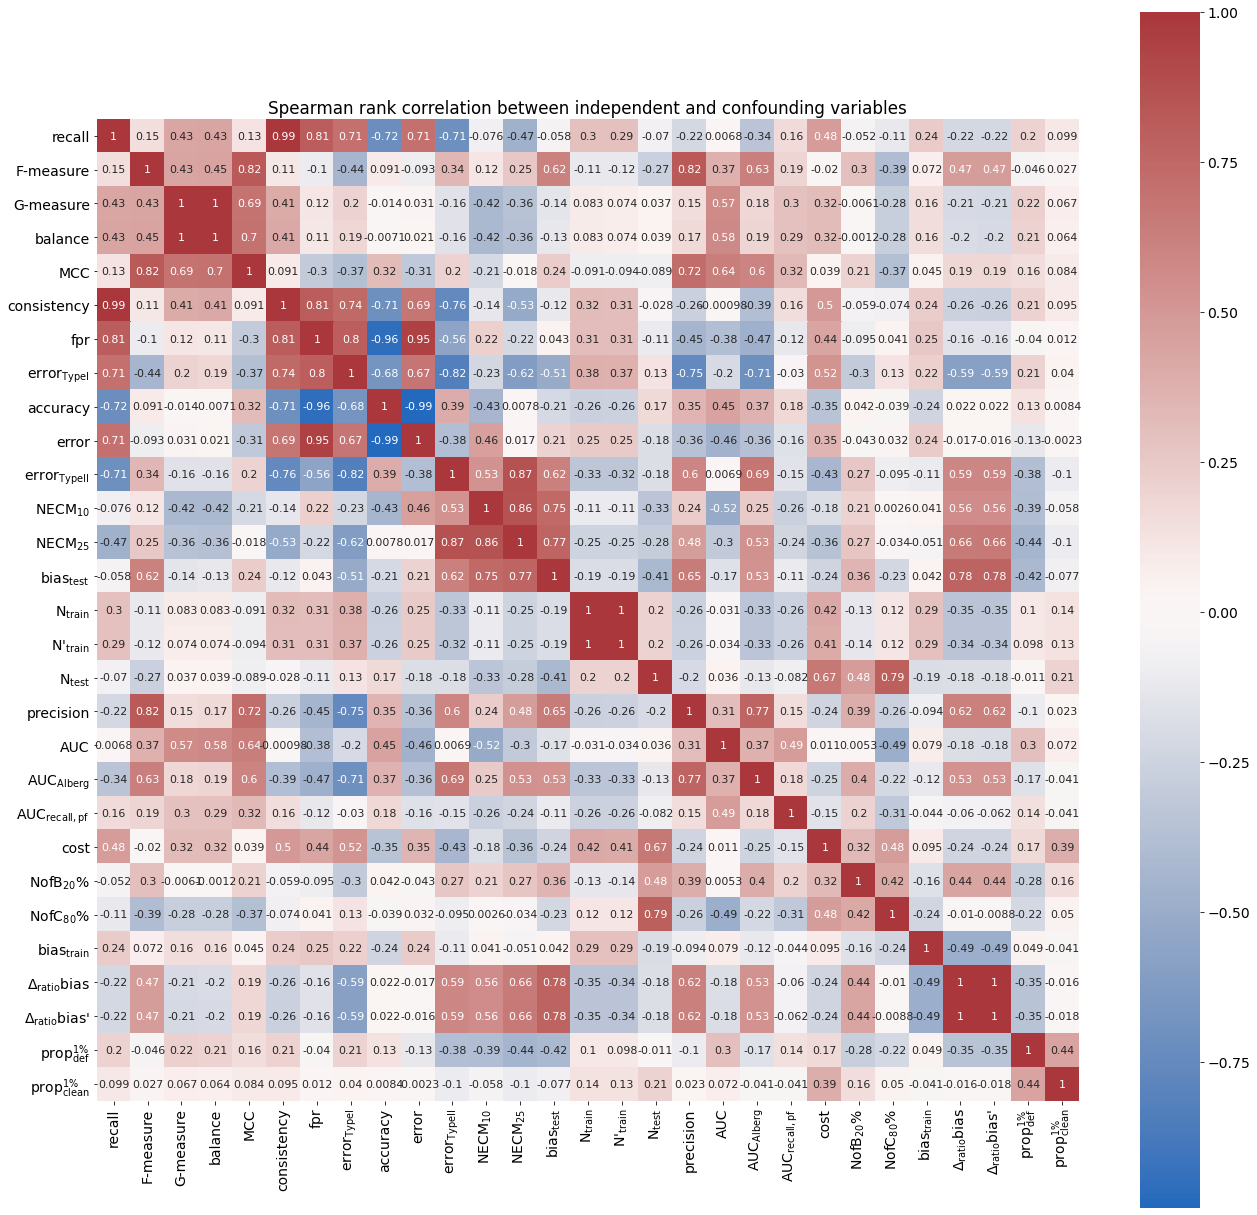

In [68]:
rs_df_numeric = rs_df[['recall', 'f_measure', 'g_measure', 'balance', 'mcc', 'consistency', 'fpr', 'error_type1', 'accuracy', 'error', 'error_type2', 'necm10', 'necm25', 'bias_test', 'num_train', 'num_train_processed', 'num_test',
'precision', 'auc', 'auc_alberg', 'auc_roi', 'cost', 'nofb20', 'nofc80', 'bias_train', 'ratio_bias', 'ratio_bias_processed', 'prop1_defect', 'prop1_clean']]

overall_spearman_corr_map_real = spearmanr(a=rs_df_numeric).correlation

fig = plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map_real, square=True, annot=True, xticklabels=df_numeric_reordered.columns,
                 yticklabels=df_numeric_reordered.columns, cmap="vlag", annot_kws={"size": heatmap_fontsize})

plt.title("Spearman rank correlation between independent and confounding variables")

update_labels(fig)
plt.savefig(os.path.join(PLOTS_DIR, "corr_all_gen.pdf"), bbox_inches='tight')
plt.show()

only cross-project


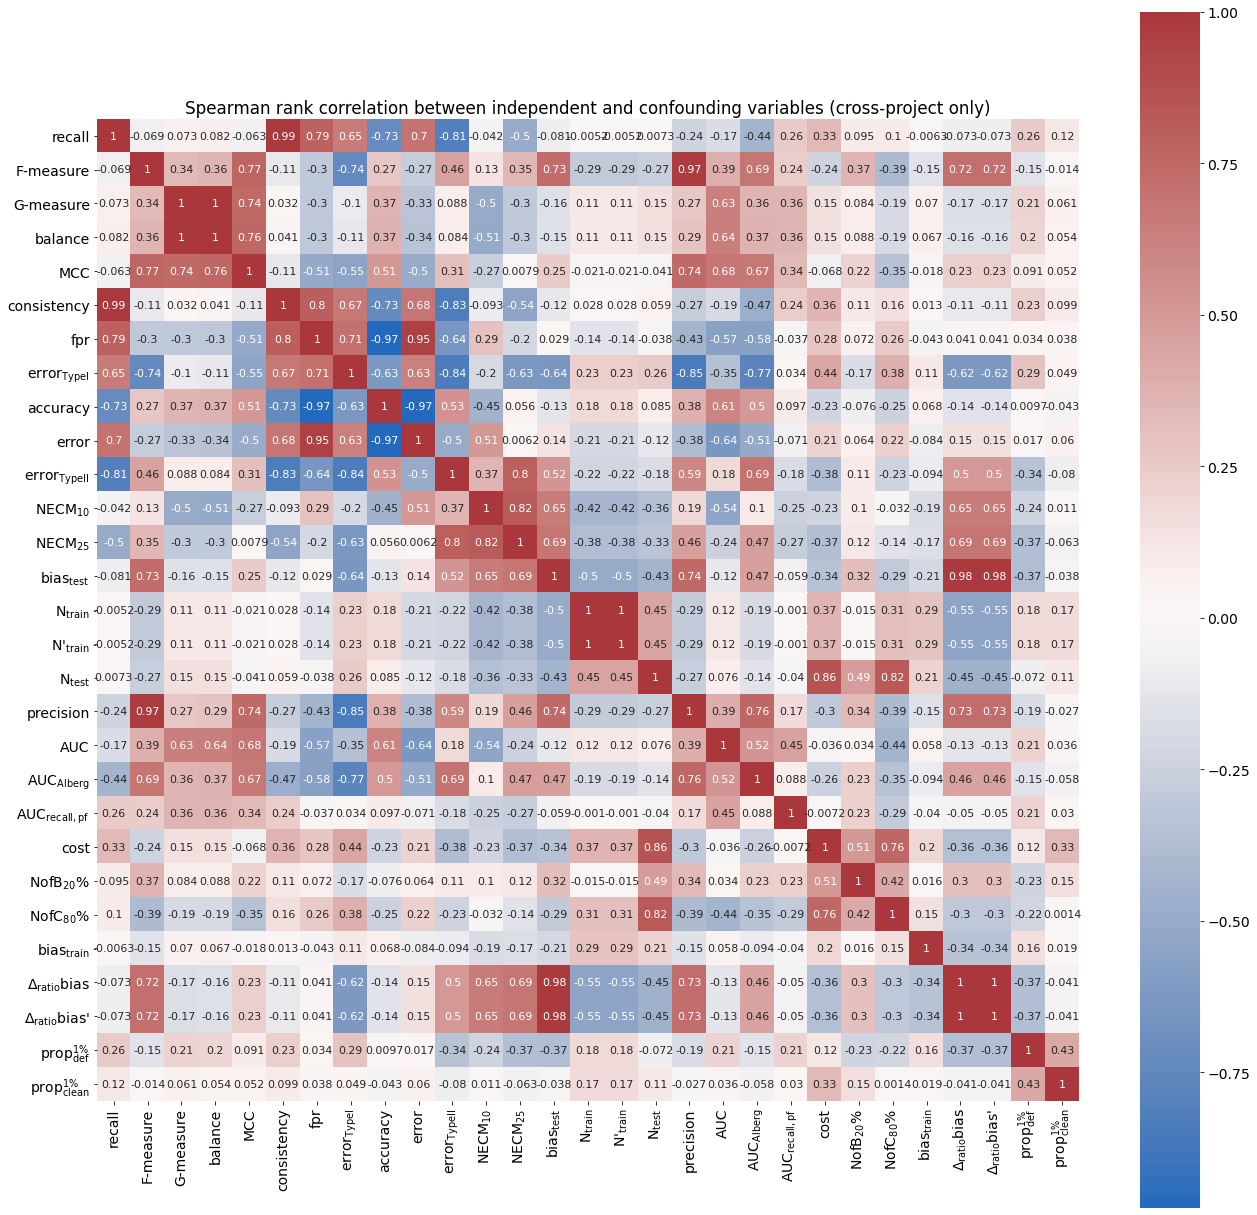

In [69]:
print('only cross-project')
rs_df_numeric = rs_df.loc[rs_df['configuration'].str.match('(4|5|6)_.*'), ['recall', 'f_measure', 'g_measure', 'balance', 'mcc', 'consistency', 'fpr', 'error_type1', 'accuracy', 'error', 'error_type2', 'necm10', 'necm25', 'bias_test', 'num_train', 'num_train_processed', 'num_test',
'precision', 'auc', 'auc_alberg', 'auc_roi', 'cost', 'nofb20', 'nofc80', 'bias_train', 'ratio_bias', 'ratio_bias_processed', 'prop1_defect', 'prop1_clean']]

overall_spearman_corr_map_real = spearmanr(a=rs_df_numeric).correlation

fig = plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map_real, square=True, annot=True, xticklabels=df_numeric_reordered.columns,
                 yticklabels=df_numeric_reordered.columns, cmap="vlag", annot_kws={"size": heatmap_fontsize})

plt.title("Spearman rank correlation between independent and confounding variables (cross-project only)")
update_labels(fig)
plt.show()

only cross-version


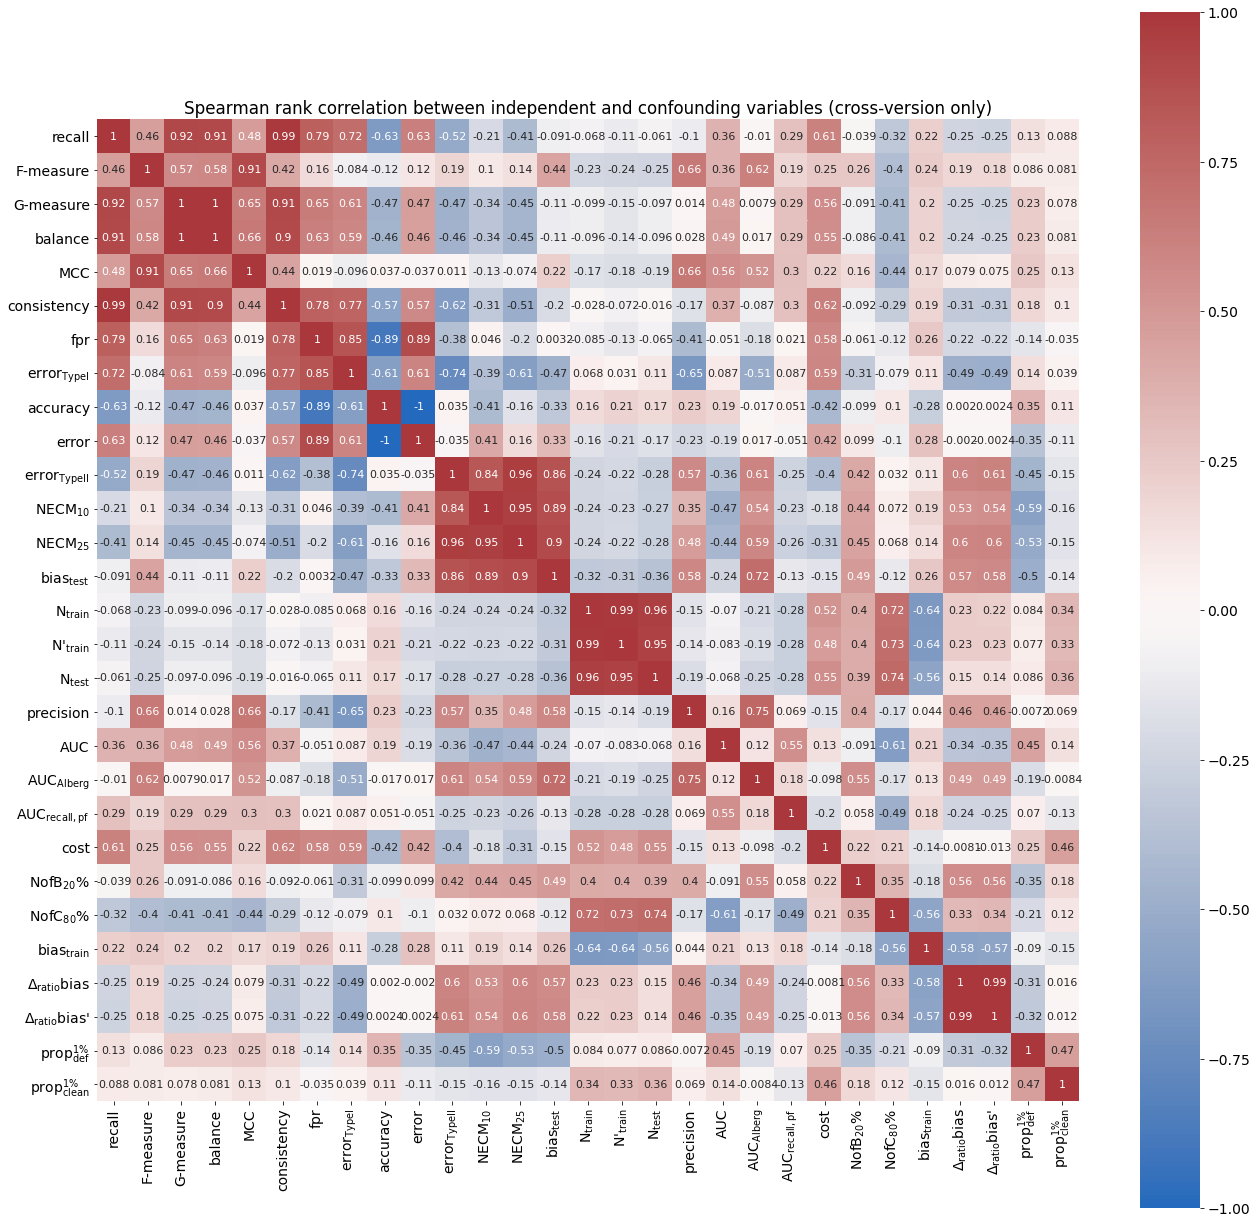

In [70]:
print('only cross-version')
rs_df_numeric = rs_df.loc[rs_df['configuration'].str.match('(1|2|3)_.*'), ['recall', 'f_measure', 'g_measure', 'balance', 'mcc', 'consistency', 'fpr', 'error_type1', 'accuracy', 'error', 'error_type2', 'necm10', 'necm25', 'bias_test', 'num_train', 'num_train_processed', 'num_test',
'precision', 'auc', 'auc_alberg', 'auc_roi', 'cost', 'nofb20', 'nofc80', 'bias_train', 'ratio_bias', 'ratio_bias_processed', 'prop1_defect', 'prop1_clean']]

overall_spearman_corr_map_real = spearmanr(a=rs_df_numeric).correlation

fig = plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map_real, square=True, annot=True, xticklabels=df_numeric_reordered.columns,
                 yticklabels=df_numeric_reordered.columns, cmap="vlag", annot_kws={"size": heatmap_fontsize})

plt.title("Spearman rank correlation between independent and confounding variables (cross-version only)")
update_labels(fig)
plt.show()

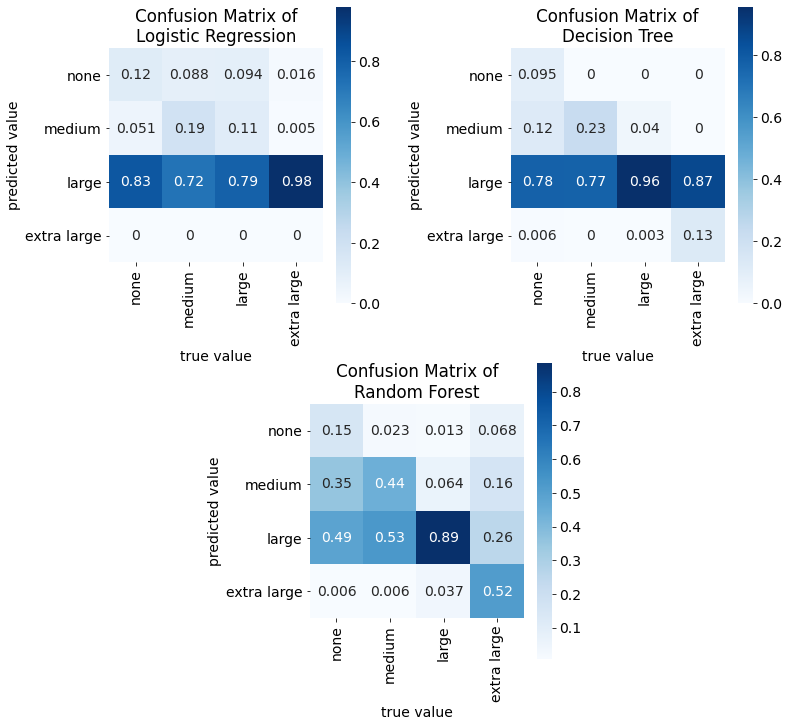

In [71]:
y_real_model_lr = model_lr.predict(X_real_unnormed[['g_measure', 'bias_test', 'num_train']])
y_real_model_dt = model_dt.predict(X_real_unnormed)
y_real_model_rf = model_rf.predict(X_real_unnormed)

fig = plt.figure(figsize=(12, 12), constrained_layout=False)
gs = fig.add_gridspec(2, 4)
gs = gridspec.GridSpec(2, 4, wspace=2)

ax = plt.subplot(gs[0, :2], )
cm = metrics.confusion_matrix(y_true=y_real, y_pred=y_real_model_lr, labels=classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.transpose()
cm_norm = np.round(cm_norm, 3)
sns.heatmap(cm_norm, square=True, annot=True, cmap="Blues", ax=ax)
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes, rotation=0)
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
ax.set_title('Confusion Matrix of\nLogistic Regression')

ax = plt.subplot(gs[0, 2:])
cm = metrics.confusion_matrix(y_true=y_real, y_pred=y_real_model_dt, labels=classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.transpose()
cm_norm = np.round(cm_norm, 3)
sns.heatmap(cm_norm, square=True, annot=True, cmap="Blues", ax=ax)
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes, rotation=0)
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
ax.set_title('Confusion Matrix of\nDecision Tree')


ax = plt.subplot(gs[1, 1:3])
cm = metrics.confusion_matrix(y_true=y_real, y_pred=y_real_model_rf, labels=classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.transpose()
cm_norm = np.round(cm_norm, 3)
sns.heatmap(cm_norm, square=True, annot=True, cmap="Blues", ax=ax)
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes, rotation=0)
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
ax.set_title('Confusion Matrix of\nRandom Forest')

update_labels(fig)
plt.savefig(os.path.join(PLOTS_DIR, "realistic_cms.pdf"), bbox_inches="tight")
plt.show()

In [72]:
positive_bt = bt_df[(bt_df['diff']>0) & (bt_df['diff']<np.inf) & ~bt_df['diff'].isna()]
X_pos_bt = positive_bt.iloc[:, 2:32]
Y_pos_bt = positive_bt.iloc[:, 32]

reg_rf = RandomForestRegressor()

reg_rf.fit(X_pos_bt, Y_pos_bt)

Y_pred_bt = reg_rf.predict(X_pos_bt)

positive_rs = rs_df[(rs_df['diff']>0) & (rs_df['diff']<np.inf) & ~rs_df['diff'].isna()]
X_pos_rs = positive_rs.iloc[:, 2:32]
Y_pos_rs = positive_rs.iloc[:, 32]

Y_pred_rs = reg_rf.predict(X_pos_rs)

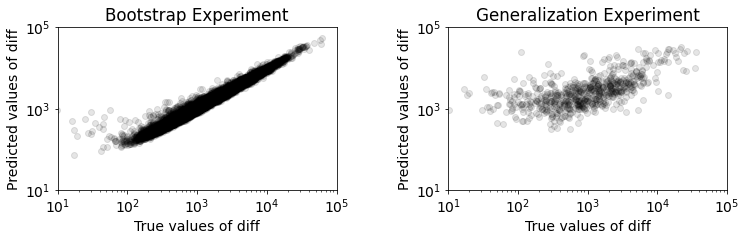

In [73]:
fig, axes = plt.subplots(1,2, figsize=(12, 3))
ax = axes[0]
ax.scatter(Y_pos_bt, Y_pred_bt, color='black', alpha=0.1)
ax.set_xlabel('True values of diff')
ax.set_ylabel('Predicted values of diff')
ax.set_title('Bootstrap Experiment')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 10**5)
ax.set_ylim(10, 10**5)


ax = axes[1]
ax.scatter(Y_pos_rs, Y_pred_rs, color='black', alpha=0.1)
ax.set_xlabel('True values of diff')
ax.set_ylabel('Predicted values of diff')
ax.set_title('Generalization Experiment')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 10**5)
ax.set_ylim(10, 10**5)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.savefig(os.path.join(PLOTS_DIR, "sensitivity_diff_prediction.png"), bbox_inches="tight")
plt.show()

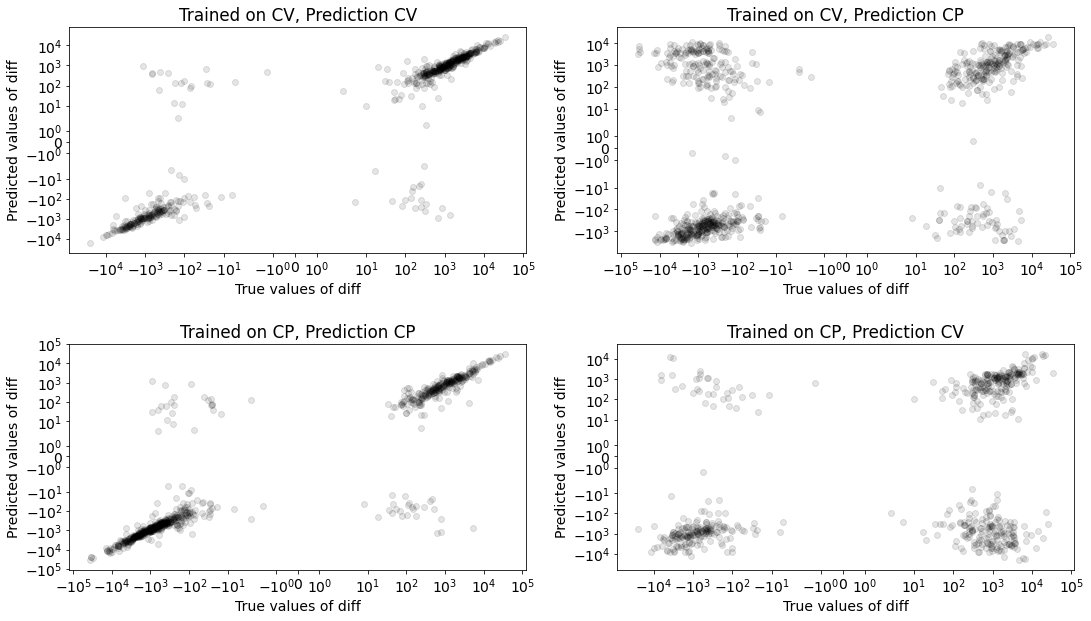

In [74]:
finite_rs = rs_df[(rs_df['diff']>-np.inf) & (rs_df['diff']<np.inf) & ~rs_df['diff'].isna()]
X_pos_rs = finite_rs.iloc[:, 2:32]
Y_pos_rs = finite_rs.iloc[:, 32]

Y_pred_rs = reg_rf.predict(X_pos_rs)

X_pos_cv = finite_rs[finite_rs['configuration'].str.match('(1|2|3).*')].iloc[:, 2:32]
Y_pos_cv = finite_rs[finite_rs['configuration'].str.match('(1|2|3).*')].iloc[:, 32]
X_pos_cp = finite_rs[finite_rs['configuration'].str.match('(4|5|6).*')].iloc[:, 2:32]
Y_pos_cp = finite_rs[finite_rs['configuration'].str.match('(4|5|6).*')].iloc[:, 32]


reg_rf_cv = RandomForestRegressor()
reg_rf_cv.fit(X_pos_cv, Y_pos_cv)

Y_pred_cv_cv = reg_rf_cv.predict(X_pos_cv)
Y_pred_cv_cp = reg_rf_cv.predict(X_pos_cp)

reg_rf_cp = RandomForestRegressor()
reg_rf_cp.fit(X_pos_cp, Y_pos_cp)

Y_pred_cp_cv = reg_rf_cp.predict(X_pos_cv)
Y_pred_cp_cp = reg_rf_cp.predict(X_pos_cp)

fig, axes = plt.subplots(2,2, figsize=(18, 10))
ax = axes[0,0]
ax.scatter(Y_pos_cv, Y_pred_cv_cv, color='black', alpha=0.1)
ax.set_xlabel('True values of diff')
ax.set_ylabel('Predicted values of diff')
ax.set_title('Trained on CV, Prediction CV')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

ax = axes[0,1]
ax.scatter(Y_pos_cp, Y_pred_cv_cp, color='black', alpha=0.1)
ax.set_xlabel('True values of diff')
ax.set_ylabel('Predicted values of diff')
ax.set_title('Trained on CV, Prediction CP')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

ax = axes[1,0]
ax.scatter(Y_pos_cp, Y_pred_cp_cp, color='black', alpha=0.1)
ax.set_xlabel('True values of diff')
ax.set_ylabel('Predicted values of diff')
ax.set_title('Trained on CP, Prediction CP')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

ax = axes[1,1]
ax.scatter(Y_pos_cv, Y_pred_cp_cv, color='black', alpha=0.1)
ax.set_xlabel('True values of diff')
ax.set_ylabel('Predicted values of diff')

ax.set_title('Trained on CP, Prediction CV')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
plt.savefig(os.path.join(PLOTS_DIR, "diff_models_cvcp.png"), bbox_inches="tight")
plt.show()

In [75]:
rs_df.groupby(['configuration', 'potential']).count()['release'] / rs_df.groupby(['configuration']).count()['release']

configuration    potential  
1_AsIs           extra_large    0.026906
                 large          0.224215
                 medium         0.295964
                 none           0.452915
2_Kawata15       extra_large    0.031390
                 large          0.331839
                 medium         0.264574
                 none           0.372197
3_Peters15       extra_large    0.076923
                 large          0.276018
                 medium         0.262443
                 none           0.384615
4_Canfora13      extra_large    0.382445
                 large          0.062696
                 medium         0.094044
                 none           0.460815
5_Watanabe08     extra_large    0.034483
                 large          0.100313
                 medium         0.184953
                 none           0.680251
6_CamargoCruz09  extra_large    0.090909
                 large          0.191223
                 medium         0.247649
                 none       

In [76]:
np.median([0.452915, 0.372197, 0.384615, 0.460815, 0.680251, 0.470219])

0.45686499999999997

In [77]:
sizes = []
for file in [f for f in os.listdir('release-level-data') if re.match(r'.*_aggregated.csv', f)]:
    sizes += pd.read_csv('release-level-data/%s' % file, sep=';', usecols = ['SM_file_lloc'])['SM_file_lloc'].tolist()

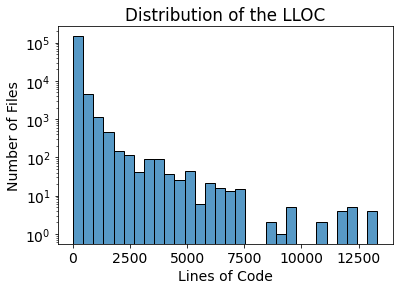

In [78]:
size_df = pd.DataFrame(sizes, columns=['LLOC'])

fig, ax = plt.subplots(1,1)
sns.histplot(size_df, log_scale=(False, True), bins=30, color="lightgray", legend=False, ax=ax)
ax.set_xlabel('Lines of Code')
ax.set_ylabel('Number of Files')
ax.set_title('Distribution of the LLOC')
plt.savefig(os.path.join(PLOTS_DIR, "lloc_distribution.pdf"), bbox_inches="tight")
plt.show()